In [1]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re

import time
import torch
import torch.nn

import random
import pickle

# import self-defined module
from utils_eval import AverageMeter

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
4
Tesla V100-SXM2-32GB


In [3]:
import torch.backends.cudnn as cudnn
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
else:
    device = torch.device("cpu")
    cudnn.benchmark=False

print(device)
print(torch.cuda.get_device_name(0))

cuda:0
Tesla V100-SXM2-32GB


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# 1. Load data

### a. Microbiome & metadata (SHOGUN)

In [5]:
### Read SHOGUN microbiome data - Voom-SNM-Quantile-Data
microbiome_shogun = pd.read_csv('./data/SHOGUN-TCGA-Voom-SNM-Quantile-Data-13517-Samples.csv', 
                               header=0, index_col=0)
### Read Metadata
metadata_shogun = pd.read_csv('./data/Metadata-TCGA-SHOGUN-13517-Samples.csv', 
                               header=0, index_col=0)

#### Merge microbime data and metadata

In [6]:
metadata_subset = metadata_shogun[['case_uuid', 'sample_uuid', 'experimental_strategy', 'sample_type']]
microbiome_metadata_shogun_df = pd.merge(left=microbiome_shogun, right=metadata_subset, how='left', 
                                         left_index=True, right_index=True)
microbiome_metadata_shogun_df['sample_uuid'] = [microbiome_metadata_shogun_df['sample_uuid'].values[i].lower() \
                                                for i in range(microbiome_metadata_shogun_df.shape[0])]

### b. Clinical variables

In [7]:
### Read clinical varaible data
clinical_immune_variables_df = pd.read_excel('./data/Master Table-Alteration in CNV, Mut, Pathway .xlsx', sheet_name='Clinical variables', 
                                             header=0, index_col=1, 
                                             na_values=['[Not Applicable]', '#N/A', '[Not Available]', 
                                                                     '[Discrepancy]', '[Not Evaluated]', '[Unknown]'])

# Remove duplicate columns
import re
for c in clinical_immune_variables_df.columns:
    if re.search('.*[.]\d', c):
        clinical_immune_variables_df = clinical_immune_variables_df.drop(columns = [c])
clinical_immune_variables_df = clinical_immune_variables_df.drop(columns = ['OS Time', 'OS.time (months)', 'OS', 
                                                                            'PFI Time', 'DSS.time (days)'])

# Pick out immune variables
imune_check_df = pd.read_csv('./data/immune_check_df.csv', header=0, index_col=0)
clinical_variables_names = imune_check_df['features'].loc[imune_check_df['immune feature (1/0)'] != 1].values
clinical_variables_df = clinical_immune_variables_df.loc[:, clinical_variables_names]

In [8]:
clinical_variables_df

PATIENT_BARCODE DISEASE  Unnamed: 14  \
SAMPLE_BARCODE                                         
TCGA-OR-A5J1-01    TCGA-OR-A5J1     ACC          NaN   
TCGA-OR-A5J2-01    TCGA-OR-A5J2     ACC          NaN   
TCGA-OR-A5J3-01    TCGA-OR-A5J3     ACC          NaN   
TCGA-OR-A5J5-01    TCGA-OR-A5J5     ACC          NaN   
TCGA-OR-A5J6-01    TCGA-OR-A5J6     ACC          NaN   
...                         ...     ...          ...   
TCGA-YZ-A980-01    TCGA-YZ-A980     UVM          NaN   
TCGA-YZ-A982-01    TCGA-YZ-A982     UVM          NaN   
TCGA-YZ-A983-01    TCGA-YZ-A983     UVM          NaN   
TCGA-YZ-A984-01    TCGA-YZ-A984     UVM          NaN   
TCGA-YZ-A985-01    TCGA-YZ-A985     UVM          NaN   

                 order in TCGA clinical data table patientBarcode  \
SAMPLE_BARCODE                                                      
TCGA-OR-A5J1-01                                1.0   TCGA-OR-A5J1   
TCGA-OR-A5J2-01                                2.0   TCGA-OR-A5J2   
TCGA-OR-A5J3-01                                3.0   TCGA-OR-A5J3   
TCGA-OR-A5J5-01                                5.0   TCGA-OR-A5J5   
TCGA-OR-A5J6-01                                6.0   TCGA-OR-A5J6   
...                                            ...            ...   
TCGA-YZ-A980-01                            11156.0   TCGA-YZ-A980   
TCGA-YZ-A982-01                            11157.0   TCGA-YZ-A982   
TCGA-YZ-A983-01                            11158.0   TCGA-YZ-A983   
TCGA-YZ-A984-01                            11159.0   TCGA-YZ-A984   
TCGA-YZ-A985-01                            11160.0   TCGA-YZ-A985   

                bcr_patient_barcode type  age_at_initial_pathologic_diagnosis  \
SAMPLE_BARCODE                                                                  
TCGA-OR-A5J1-01        TCGA-OR-A5J1  ACC                                 58.0   
TCGA-OR-A5J2-01        TCGA-OR-A5J2  ACC                                 44.0   
TCGA-OR-A5J3-01        TCGA-OR-A5J3  ACC                                 23.0   
TCGA-OR-A5J5-01        TCGA-OR-A5J5  ACC                                 30.0   
TCGA-OR-A5J6-01        TCGA-OR-A5J6  ACC                                 29.0   
...                             ...  ...                                  ...   
TCGA-YZ-A980-01        TCGA-YZ-A980  UVM                                 75.0   
TCGA-YZ-A982-01        TCGA-YZ-A982  UVM                                 79.0   
TCGA-YZ-A983-01        TCGA-YZ-A983  UVM                                 51.0   
TCGA-YZ-A984-01        TCGA-YZ-A984  UVM                                 50.0   
TCGA-YZ-A985-01        TCGA-YZ-A985  UVM                                 41.0   

                 gender                       race  ...  \
SAMPLE_BARCODE                                      ...   
TCGA-OR-A5J1-01    MALE                      WHITE  ...   
TCGA-OR-A5J2-01  FEMALE                      WHITE  ...   
TCGA-OR-A5J3-01  FEMALE                      WHITE  ...   
TCGA-OR-A5J5-01    MALE                      WHITE  ...   
TCGA-OR-A5J6-01  FEMALE  BLACK OR AFRICAN AMERICAN  ...   
...                 ...                        ...  ...   
TCGA-YZ-A980-01    MALE                      WHITE  ...   
TCGA-YZ-A982-01  FEMALE                      WHITE  ...   
TCGA-YZ-A983-01  FEMALE                      WHITE  ...   
TCGA-YZ-A984-01  FEMALE                      WHITE  ...   
TCGA-YZ-A985-01  FEMALE                      WHITE  ...   

                Intratumor Heterogeneity Proliferation Wound Healing  \
SAMPLE_BARCODE                                                         
TCGA-OR-A5J1-01                     0.02       -1.2768       -0.0515   
TCGA-OR-A5J2-01                     0.16       -0.5351       -0.2730   
TCGA-OR-A5J3-01                     0.11       -1.0503       -0.1125   
TCGA-OR-A5J5-01                     0.15        0.0606        0.0060   
TCGA-OR-A5J6-01                     0.06       -2.2332       -0.4140   
...                                  ...           ...         

# 2. Process and merge data

In [9]:
def remove_missing_rows(dataset, microbiome_column_index):
    start_idx = microbiome_column_index[0]
    end_idx = microbiome_column_index[1]
    
    na_idx = np.where(pd.isna(dataset.iloc[:,start_idx:end_idx]).sum(axis=1)==(end_idx-start_idx))[0]
    dataset_nona = dataset.drop(dataset.index[na_idx], axis=0)
    return dataset_nona

In [10]:
def subsetting(dataset, columns, remain_value_list):
    for column, remain_value in zip(columns, remain_value_list):
        idx_remain = np.isin(dataset.loc[:, column], remain_value)
        dataset = dataset.loc[idx_remain, :]
    return dataset

In [11]:
def merge_clinical_microbiome(disease, clinical_variables_df, microbiome_metadata_shogun_df, 
                              subsetting_columns=['sample_type', 'experimental_strategy'], 
                              remain_value_list=[['Primary Tumor'], ['RNA-Seq']]):
    
    
    ### Read clinical data
    clinical_variables_df_disease = clinical_variables_df.loc[clinical_variables_df['DISEASE'] == disease,:]
    import re
    na_col_idx = np.where([re.search('Unnamed.*', clinical_variables_df_disease.columns[i]) 
                          for i in range(clinical_variables_df_disease.shape[1])])
    rm_col_name = ['type','order in TCGA clinical data table', 'patientBarcode', 'bcr_patient_barcode',
                  'barcode', 'TCGA Participant Barcode', 'TCGA Study']

    clinical_variables_df_disease = clinical_variables_df_disease.\
        drop(columns=list(clinical_variables_df_disease.columns[na_col_idx]) + rm_col_name)
    
    print('========================================================================')
    print(disease.upper())
    print('< Clinical Variables >')
    print('Total sample #:', clinical_variables_df_disease.shape[0])
    print('Unique patient #:', len(np.unique(clinical_variables_df_disease['PATIENT_BARCODE'])))

    ### Biospecimen data

    ### Read biospecimen data from GDC data portal 
    ### Reference: https://www.biostars.org/p/200546/
    import json

    fileName='./data/biospecimen.project-TCGA-{}.2021-10-14.json'.format(disease)

    with open(fileName) as data_file:    
        biospecimen = json.load(data_file)

    id_list = []
    for i in range(len(biospecimen)):
        for j in range(len(biospecimen[i]['samples'])):
            id_list.append([biospecimen[i]['case_id'], biospecimen[i]['samples'][j]['submitter_id'],
                           biospecimen[i]['samples'][j]['sample_id'], biospecimen[i]['samples'][j]['is_ffpe'],
                           biospecimen[i]['samples'][j]['sample_type']])
    id_df = pd.DataFrame(id_list, columns=['case_uuid', 'sample_id', 'sample_uuid', 'is_ffpe', 'sample_type_bs'])
    id_df = id_df.sort_values(by=['sample_id'])
    id_df['sample_id'] = [id_df['sample_id'].values[i][:-1] for i in range(id_df.shape[0])]
    id_df = id_df.drop_duplicates(subset=['sample_id'])

    print('< biospecimen data >')
    print('Biospecimen sample #:', id_df.shape[0])
    print('sample_type_bs:', list(np.unique(id_df['sample_type_bs'])))

    #### Merge mutation/CNV OR clinical data with biospecimen data and microbiome data

    clinical_variables_df_disease_uuid = pd.merge(left=clinical_variables_df_disease, right=id_df, 
                                               how='left', left_index=True, right_on='sample_id')
    clinical_variables_df_disease_microbiome = pd.merge(left=clinical_variables_df_disease_uuid, 
                                                     right=microbiome_metadata_shogun_df,
                                                     how='left', on='sample_uuid')
    clinical_variables_df_disease_microbiome.index = clinical_variables_df_disease_microbiome['sample_id']
    
    ### Remove rows with no corresponding microbiome data
    microbiome_column_index = [clinical_variables_df_disease_uuid.shape[1], 
                               clinical_variables_df_disease_microbiome.shape[1]-3]
    clinical_variables_df_disease_microbiome_nona = remove_missing_rows(clinical_variables_df_disease_microbiome, 
                                                                     microbiome_column_index)
    clinical_variables_df_disease_microbiome_clean = subsetting(clinical_variables_df_disease_microbiome_nona, 
                                                    subsetting_columns, remain_value_list)
    clinical_variables_df_disease_microbiome_clean.drop_duplicates(subset='sample_id', inplace=True)
    microbiome_clean = clinical_variables_df_disease_microbiome_clean.iloc[:, microbiome_column_index[0]:microbiome_column_index[1]]
    print('< Merged data >')
    print('Merged data shape:', clinical_variables_df_disease_microbiome_clean.shape)
    print('Microbiome data shape:', microbiome_clean.shape)
    print('sample_type:', list(np.unique(clinical_variables_df_disease_microbiome_clean['sample_type'])))
    
    ### Saving data
    import os
    os.makedirs('./data/processed data', exist_ok=True)
    clinical_variables_df_disease_microbiome_clean.\
        to_pickle('./data/processed data/{}_clinical_variables_disease_microbiome_clean.pkl'.format(disease))
    microbiome_clean.\
        to_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))

    return clinical_variables_df_disease_microbiome_clean, microbiome_clean


In [12]:
COAD_clinical_variables_disease_microbiome_clean, COAD_microbiome_clean = \
    merge_clinical_microbiome(disease='COAD', clinical_variables_df=clinical_variables_df,
                              microbiome_metadata_shogun_df=microbiome_metadata_shogun_df,
                              remain_value_list=[['Metastatic', 'Primary Tumor', 'Recurrent Tumor'], ['RNA-Seq']])
STAD_clinical_variables_disease_microbiome_clean, STAD_microbiome_clean = \
    merge_clinical_microbiome(disease='STAD', clinical_variables_df=clinical_variables_df,
                              microbiome_metadata_shogun_df=microbiome_metadata_shogun_df,
                              remain_value_list=[['Primary Tumor'], ['RNA-Seq']])

COAD
< Clinical Variables >
Total sample #: 341
Unique patient #: 341
< biospecimen data >
Biospecimen sample #: 978
sample_type_bs: ['Blood Derived Normal', 'Metastatic', 'Primary Tumor', 'Recurrent Tumor', 'Solid Tissue Normal']
< Merged data >
Merged data shape: (164, 1671)
Microbiome data shape: (164, 1594)
sample_type: ['Primary Tumor']
STAD
< Clinical Variables >
Total sample #: 383
Unique patient #: 383
< biospecimen data >
Biospecimen sample #: 940
sample_type_bs: ['Blood Derived Normal', 'Primary Tumor', 'Solid Tissue Normal']
< Merged data >
Merged data shape: (380, 1671)
Microbiome data shape: (380, 1594)
sample_type: ['Primary Tumor']


# 3. Prediction by MLPs

In [13]:
### remove nan values
def remove_nan(y):
    nan_idx = np.where(pd.isna(y))[0]
    return y.drop(y.index[nan_idx], axis=0)

In [14]:
### Discretize the continuous variables into 2 or 3 categories - low, (moderate), high
def if_discretize(y_nonan):
    if y_nonan.dtype.name == 'object':
        y_disc = y_nonan
    elif len(np.unique(y_nonan)) <= 6:
        y_disc = y_nonan
    elif np.quantile(y_nonan, 1/2)==np.min(y_nonan):
        y_disc = pd.Series(np.where(y_nonan==np.min(y_nonan), 'Min', 'Not Min'), index=y_nonan.index)
    elif np.quantile(y_nonan, 1/2)==np.max(y_nonan):
        y_disc = pd.Series(np.where(y_nonan==np.max(y_nonan), 'Not Max', 'Max'), index=y_nonan.index)
    elif np.quantile(y_nonan, 1/3)==np.min(y_nonan) or np.quantile(y_nonan, 2/3)==np.max(y_nonan):
        y_disc = pd.qcut(y_nonan, 2, labels=['Low', 'High'])
    else:
        y_disc = pd.qcut(y_nonan, 3, labels=['Low', 'Moderate', 'High'])
    
    ### remove categories with less than 5 instances (8/2 training/testing split)
    u, c = np.unique(y_disc, return_counts=True)
    idx = np.where(np.isin(y_disc, u[c<5]))
    return y_disc.drop(index=y_disc.index[idx])

In [15]:
def balanced_over_sampling(X, y, random_seed=123):
    np.random.seed(random_seed)
    unique_value, unique_value_counts = np.unique(y, return_counts=True)
    train_class_max = np.max(unique_value_counts)
    train_samples_idx = []
    for i, y_unique in enumerate(unique_value):
        train_one_class_idx = np.where(y==y_unique)[0]
        train_one_sample_idx = np.concatenate([train_one_class_idx,
                                               np.random.choice(train_one_class_idx, 
                                                                size=train_class_max-len(train_one_class_idx), replace=True)])
        train_samples_idx.append(train_one_sample_idx)
    train_balanced_idx = np.random.permutation(np.concatenate(train_samples_idx))
    return X[train_balanced_idx], y[train_balanced_idx]

In [16]:
class Classifier(torch.nn.Module):
    def __init__(self, n_in_features, net_hidden_structure, n_out_features, dropout_rate):
        super(Classifier, self).__init__()
        net_fcs = []
        structure = net_hidden_structure
        net_in_shape = n_in_features
        for i, net_n_hidden_nodes in enumerate(structure):
            net_fcs.append(torch.nn.Linear(net_in_shape, net_n_hidden_nodes))
            net_fcs.append(torch.nn.BatchNorm1d(net_n_hidden_nodes))
            net_fcs.append(torch.nn.ReLU6())
            net_fcs.append(torch.nn.Dropout(p=dropout_rate))
            net_in_shape = net_n_hidden_nodes
        net_fcs.append(torch.nn.Linear(net_in_shape, n_out_features))
        self.net_fcs = torch.nn.ModuleList(net_fcs)
        
    def forward(self, x):
        net_fcs = self.net_fcs
        for net_fc in net_fcs:
            x = net_fc(x)
        return x

In [17]:
from torch.utils.data import Dataset, DataLoader
class Dataset(Dataset):
    """Self-defined dataset."""

    def __init__(self, X, y):
        """
        Args:
            X: microbiome data
            y: response data
        """
        self.X = torch.from_numpy(X).float() if not torch.is_tensor(X) else X.float()
        self.y = torch.LongTensor(y) if not torch.is_tensor(y) else y.long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
# train function
from utils_eval import AverageMeter

def train(epoch, classifier, criterion, optimizer, train_loader, gradient_clip=3, device='cpu'):
    """
    One epoch training
    """
    
    classifier.train()
    losses = AverageMeter()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.size(0)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ===================forward=====================
        outputs = classifier(data)
        loss = criterion(outputs, target)

        # ===================backward=====================
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), gradient_clip)
        optimizer.step()
        
        # ===================meters=====================
        losses.update(loss.item(), batch_size)
        loss_return = losses.avg
    
    return loss_return

In [19]:
def train_mlp(X,y, disease, batch_size, n_epoch, gradient_clip, dropout_rate, weight_decay,
              lr=0.001, momentum=0.9, random_state=123, device='cuda:0', print_loss=True,
              save_folder='./'):
    
    import torch
    import torch.nn as nn
    import random
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)
    #torch.set_deterministic(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        
    ###
    y_nonan = remove_nan(y)
    y_nonan_disc = if_discretize(y_nonan)
    X_nonan = X.loc[y_nonan_disc.index,:]
    
    ### training, testing split
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_nonan, y_nonan_disc, test_size=0.2, 
                                                        random_state=random_state, stratify=y_nonan_disc)
    X_train_balanced, y_train_balanced = balanced_over_sampling(np.array(X_train), np.array(y_train))

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(y_nonan_disc)
    y_train_balanced_le = le.transform(y_train_balanced)
    y_test_le = le.transform(y_test)
    classes = le.classes_
    label_dim = len(classes)

    # train_data = torch.utils.data.TensorDataset(torch.tensor(np.array(X_train, dtype='float32')), torch.LongTensor(y_train_le))
    # test_data = torch.utils.data.TensorDataset(torch.tensor(np.array(X_test, dtype='float32')), torch.LongTensor(y_test_le))

    train_data = Dataset(np.array(X_train_balanced), np.array(y_train_balanced_le))
    test_data = Dataset(np.array(X_test), np.array(y_test_le))
    if X_train_balanced.shape[0]%batch_size==1:
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    else:
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

    classifier = Classifier(n_in_features=X.shape[1], net_hidden_structure = [512, 128, 32, 8], 
                            n_out_features=label_dim, dropout_rate=dropout_rate)
    classifier.to(device)
    criterion = nn.CrossEntropyLoss() # nn.CrossEntropyLoss combines log_softmax and NLLLoss
    optimizer = torch.optim.SGD(classifier.parameters(), lr=lr, momentum=momentum, weight_decay = weight_decay)
    
    # =========================
    from utils_eval import AverageMeter
    
    hist = dict()
    hist['train_loss'] = []
    hist['test_loss'] = []

    for epoch in range(n_epoch):
        # Train
        train_loss = train(epoch, classifier, criterion, optimizer, train_loader, gradient_clip=gradient_clip, 
                           device=device)
        hist['train_loss'].append(train_loss)

        # test
        classifier.eval()
        test_losses = AverageMeter()

        with torch.no_grad():
            for idx, (data, target) in enumerate(test_loader):
                batch_size = data.size(0)
                data, target = data.to(device), target.to(device)

                # ===================forward=====================
                outputs = classifier(data)
                test_loss = criterion(outputs, target)
                # ===================meters======================
                test_losses.update(test_loss.item(), batch_size)

            hist['test_loss'].append(test_losses.avg)
        if print_loss:
            print('Epoch {} \ttrain_loss\t{}\ttest_loss\t{}'.format(epoch, train_loss, test_losses.avg))
    
    model_save_path = os.path.join(save_folder, 'models/{}/{}'.format(disease, y.name))
    os.makedirs(model_save_path, exist_ok=True)

    torch.save({
                'epoch': n_epoch,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': hist
                }, os.path.join(model_save_path, '{}.pth'.format(y_train.name)))
    return classifier, optimizer, hist, X_test, y_test_le, classes, (y_train, y_test)

In [20]:
def plot_loss(hist, disease, y, save_folder='./'):
    
    fig = plt.figure(figsize=(16,8))

    plt.plot(np.arange(len(hist['train_loss'])), hist['train_loss'], 
                 label='Training loss', alpha=0.8)

    plt.plot(np.arange(len(hist['test_loss'])), hist['test_loss'], 
                 label='Testing loss', alpha=0.8)

    plt.xlabel('Epoches', fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Loss (Covariate = {})'.format(y.name), fontsize=20)
    plt.legend(fontsize=20)
    plt.show()
    
    figure_save_path = os.path.join(save_folder, 'figures/{}/{}'.format(disease, y.name))
    os.makedirs(figure_save_path, exist_ok=True)
    fig.savefig(os.path.join('./figures/{}/{}/train_val_losses.pdf'.format(disease, y.name)))

In [21]:
def micro_avg_auc(y_test_le, classes, pred_proba):
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    
    y_test = label_binarize(classes[y_test_le], classes=classes)
    if y_test.shape[1]==1:
        y_test = np.hstack((1-y_test, y_test))
    y_score = pred_proba.cpu().numpy()
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    return roc_auc

In [22]:
def predict_mlp(classifier, optimizer, X_test, y_test_le, classes, device='cpu'):
    classifier.eval()
    with torch.no_grad():
        prediction = classifier(torch.tensor(np.array(X_test, dtype='float32')).to(device))
        pred_proba = torch.nn.Softmax(dim=1)(prediction)
    y_pred = classes[pred_proba.argmax(axis=1).cpu().numpy()]
    y_test_true = classes[y_test_le]
    
    accuracy = sum(y_pred==y_test_true)/len(y_pred)
    
    from sklearn.metrics import confusion_matrix
    confusion_mat = confusion_matrix(y_test_true, y_pred)
    
    auc_micro_avg = micro_avg_auc(y_test_le, classes, pred_proba)
    
    from sklearn.metrics import roc_auc_score
    y_pred_proba = pred_proba[:,1].cpu().numpy() if pred_proba.shape[1]==2 else pred_proba.cpu().numpy()
    auc_weighted_avg = roc_auc_score(y_test_true, y_pred_proba, multi_class='ovr', average="weighted")
    
    return pred_proba, y_pred, accuracy, confusion_mat, (auc_micro_avg, auc_weighted_avg)
    

In [23]:
def train_mlp_all_cols(disease, nan_percentage_cutoff=0.4, device='cuda:0', save_folder='./'):
    clinical_variables_disease_microbiome_clean = \
        pd.read_pickle('./data/processed data/{}_clinical_variables_disease_microbiome_clean.pkl'.format(disease))

    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))
    col_idx = clinical_variables_disease_microbiome_clean.shape[1] - X_microbiome.shape[1] - 3 - 5
    y_clinical_all = clinical_variables_disease_microbiome_clean.iloc[:,2:col_idx]

    ### Remove columns that have >40% (or a preset value) nan values for all samples
    y_clinical_all_rmv_idx = np.where(y_clinical_all.\
                          apply(lambda x: sum(pd.isna(x))/len(x), axis=0) > nan_percentage_cutoff)[0]
    y_clinical_all.drop(columns=y_clinical_all.columns[y_clinical_all_rmv_idx], inplace=True)

    ### Remove columns with a single response after discretization
    y_1value_idx = y_clinical_all.apply(lambda x: len(np.unique(if_discretize(remove_nan(x)))), axis=0)==1
    y_clinical_all.drop(columns=y_clinical_all.columns[y_1value_idx], inplace=True)
        
    ### Remove columns with < 5 instances after discretization
    y_less5_ins_idx = y_clinical_all.apply(lambda y: if_discretize(remove_nan(y)).shape[0] < 5, axis=0)
    y_clinical_all.drop(columns=y_clinical_all.columns[y_less5_ins_idx], inplace=True)

    accuracy_clinical_variables = []
    auc_clinical_variables = []
    y_pred_clinical_variables = []
    confusion_mat_clinical_variables = []
    pred_proba_clinical_variables = []
    classes_clinical_variables = []
    y_train_test_clinical_variables = []
    
    for i in range(y_clinical_all.shape[1]):
        classifier, optimizer, hist, X_test, y_test_le, classes, y_train_test = \
            train_mlp(X=X_microbiome, y=y_clinical_all.iloc[:,i],
            disease=disease, batch_size=32, n_epoch=1000, device=device,
            gradient_clip=2, dropout_rate=0.4, weight_decay=0.1, 
            print_loss=False, save_folder=save_folder)
        plot_loss(hist, disease, y_clinical_all.iloc[:,i], save_folder=save_folder)
        pred_proba, y_pred, accuracy, confusion_mat, auc = predict_mlp(classifier, optimizer, X_test, y_test_le, 
                                                                       classes, device=device)
        accuracy_clinical_variables.append(accuracy)
        auc_clinical_variables.append(auc)
        y_pred_clinical_variables.append(y_pred)
        confusion_mat_clinical_variables.append(confusion_mat)
        pred_proba_clinical_variables.append(pred_proba)
        classes_clinical_variables.append(classes)
        y_train_test_clinical_variables.append(y_train_test)

    import os
    result_save_folder = os.path.join(save_folder, 'results/{}'.format(disease))
    os.makedirs(result_save_folder, exist_ok=True)
    
    prediction_result_dict = dict()
    prediction_result_dict['accuracy'] = dict(zip(y_clinical_all.columns, accuracy_clinical_variables))
    prediction_result_dict['auc'] = dict(zip(y_clinical_all.columns, auc_clinical_variables))
    prediction_result_dict['y_pred'] = dict(zip(y_clinical_all.columns, y_pred_clinical_variables))
    prediction_result_dict['confusion_matrix'] = dict(zip(y_clinical_all.columns, confusion_mat_clinical_variables))
    prediction_result_dict['pred_proba'] = dict(zip(y_clinical_all.columns, pred_proba_clinical_variables))
    prediction_result_dict['classes'] = dict(zip(y_clinical_all.columns, classes_clinical_variables))
    prediction_result_dict['y_train_test'] = dict(zip(y_clinical_all.columns, y_train_test_clinical_variables))

    with open(os.path.join(result_save_folder, '{}_prediction_result_dict.pkl'.format(disease)), 'wb') as f:
        pickle.dump(prediction_result_dict, f)
    
    return prediction_result_dict

### COAD

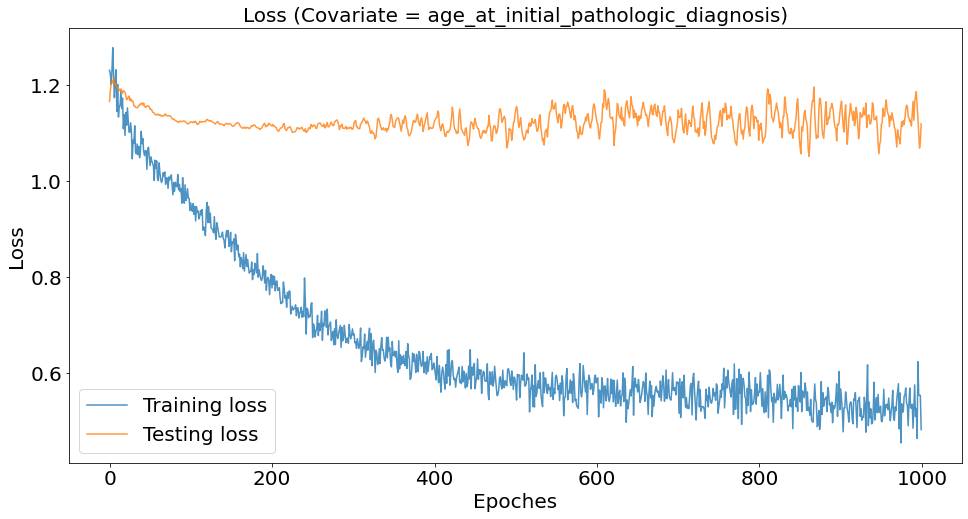

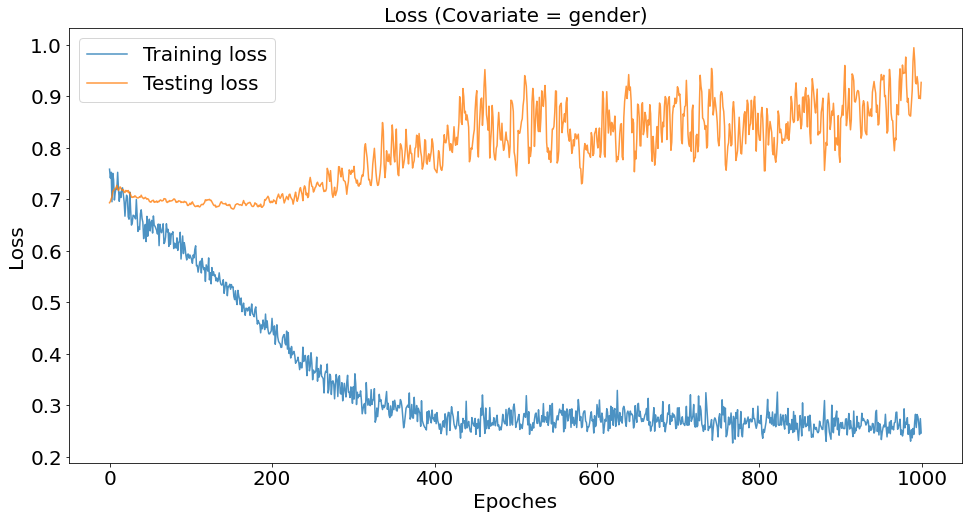

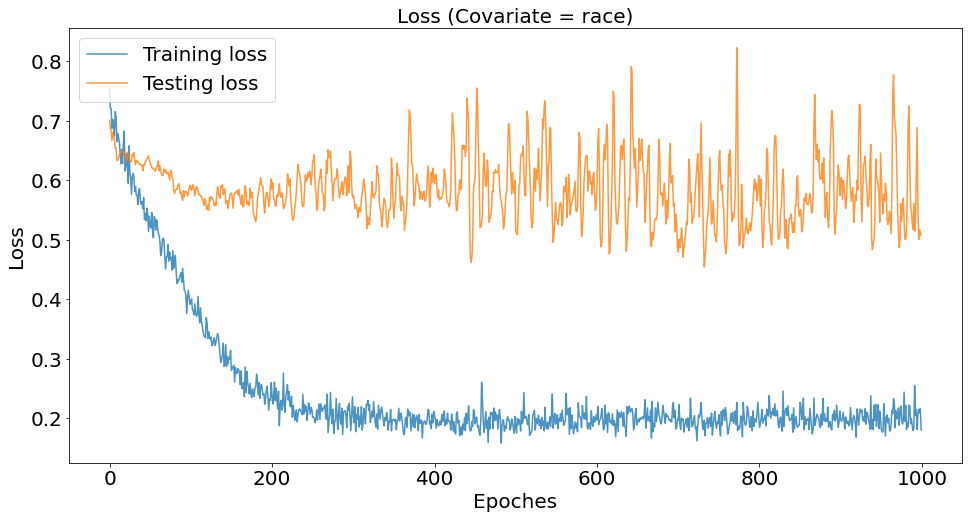

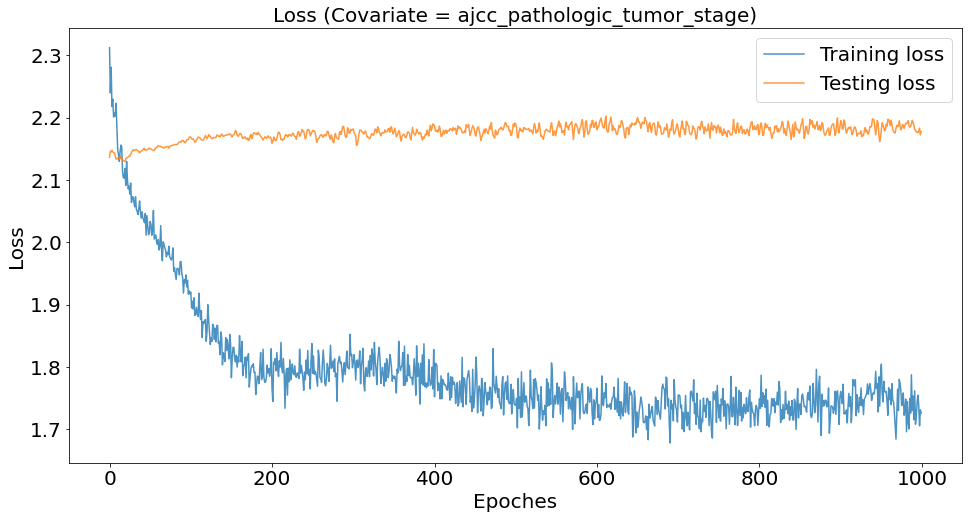

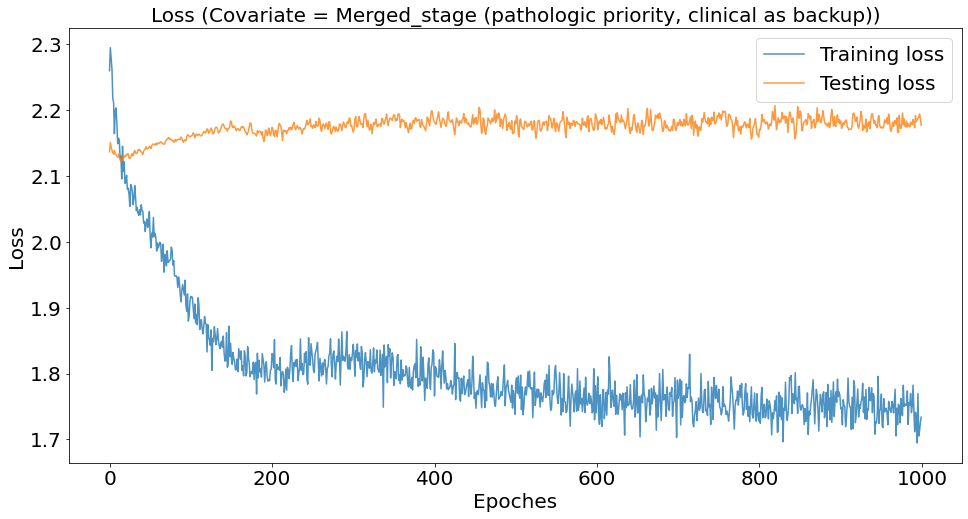

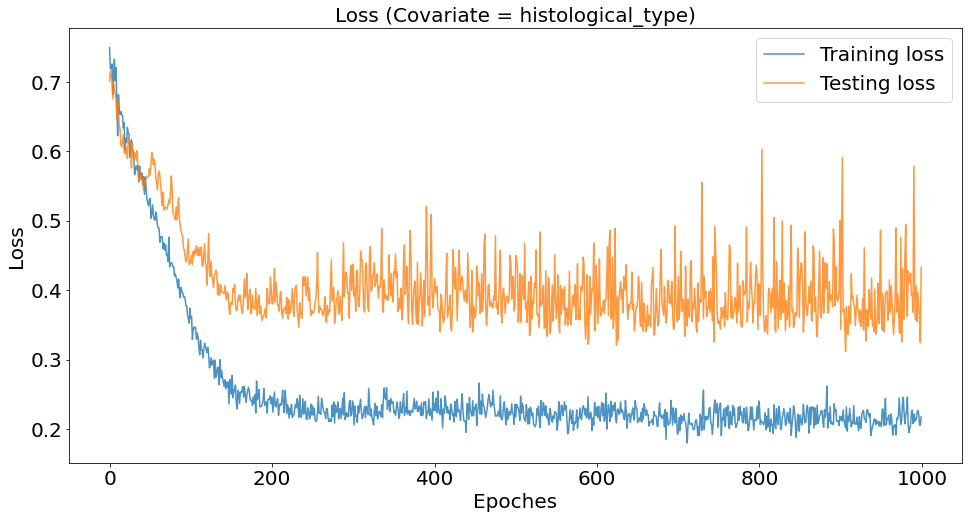

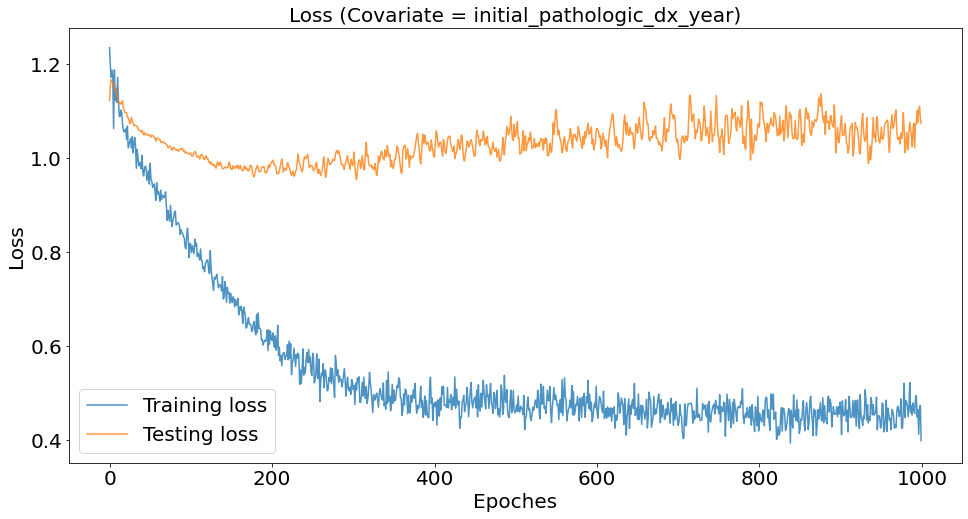

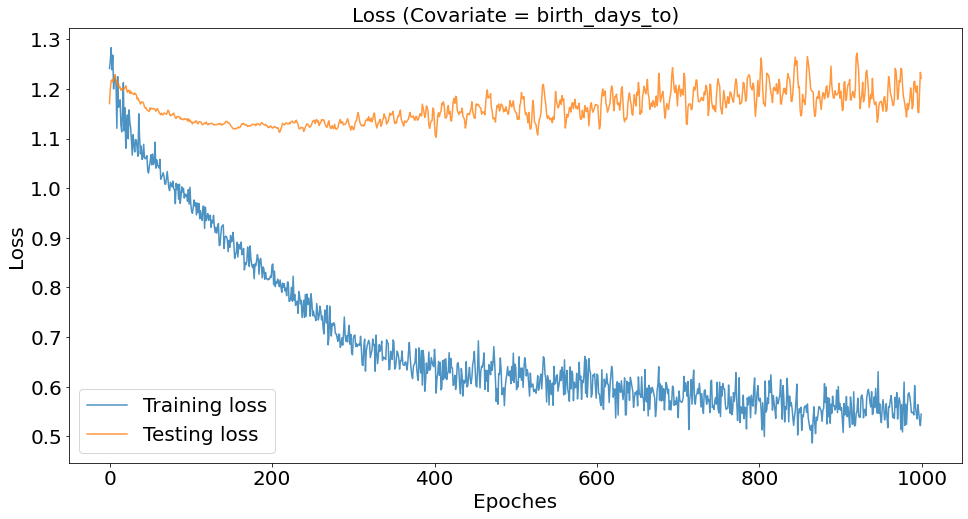

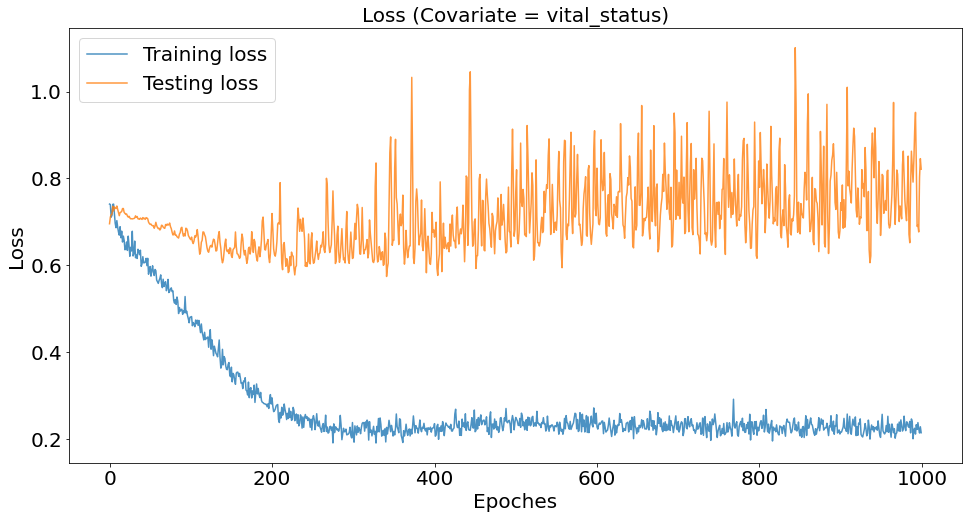

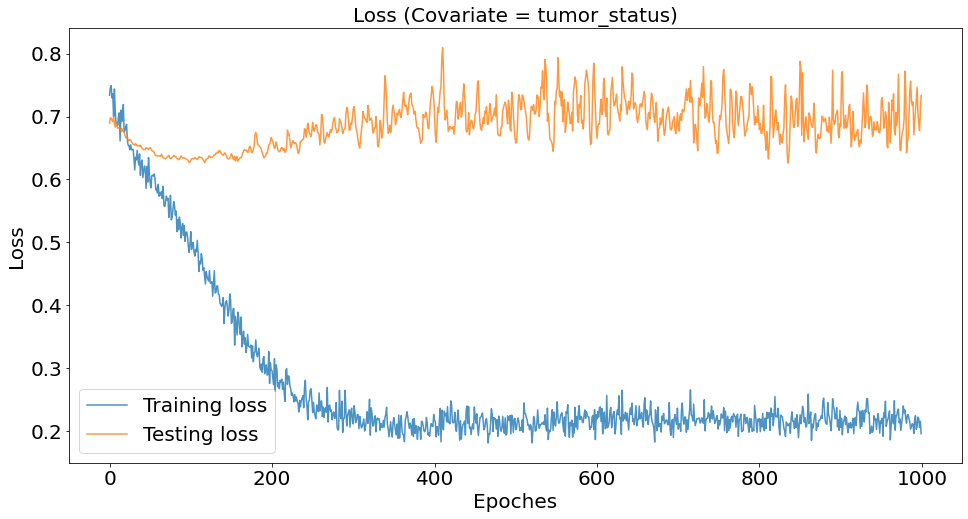

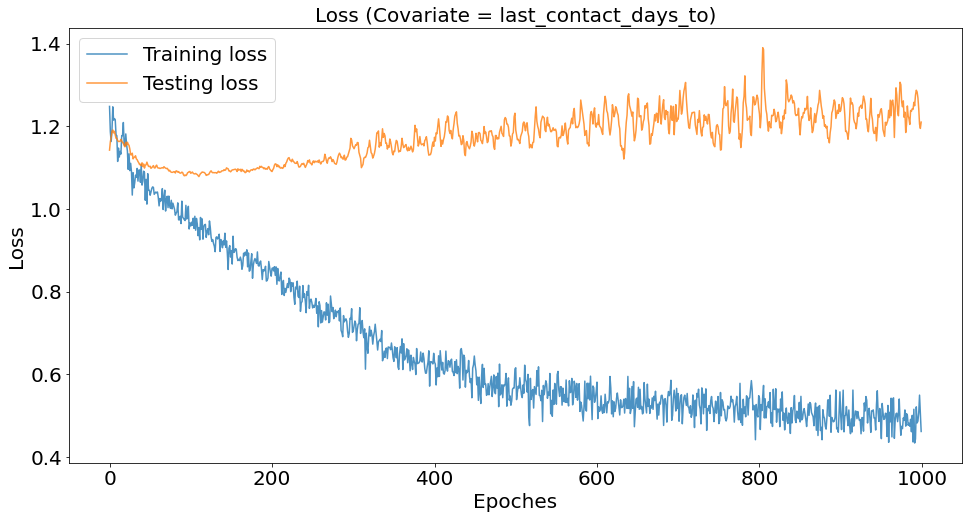

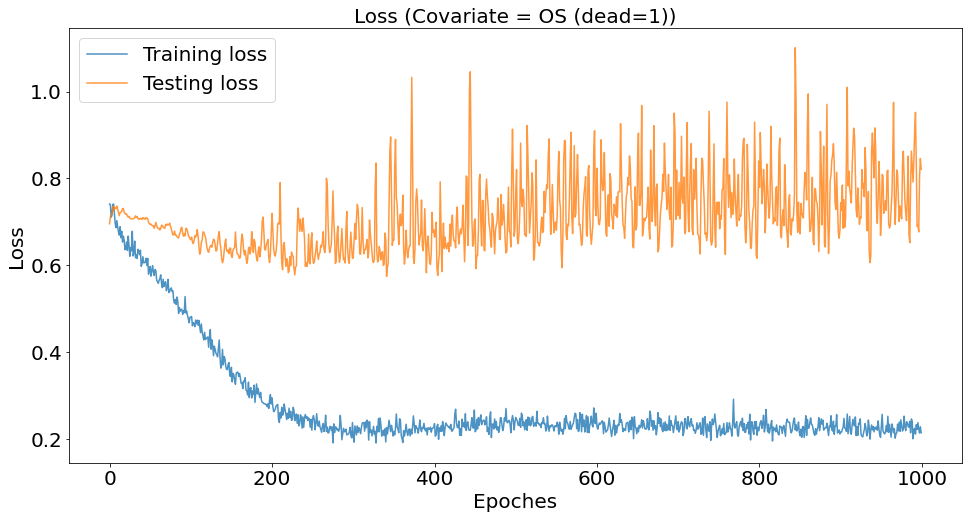

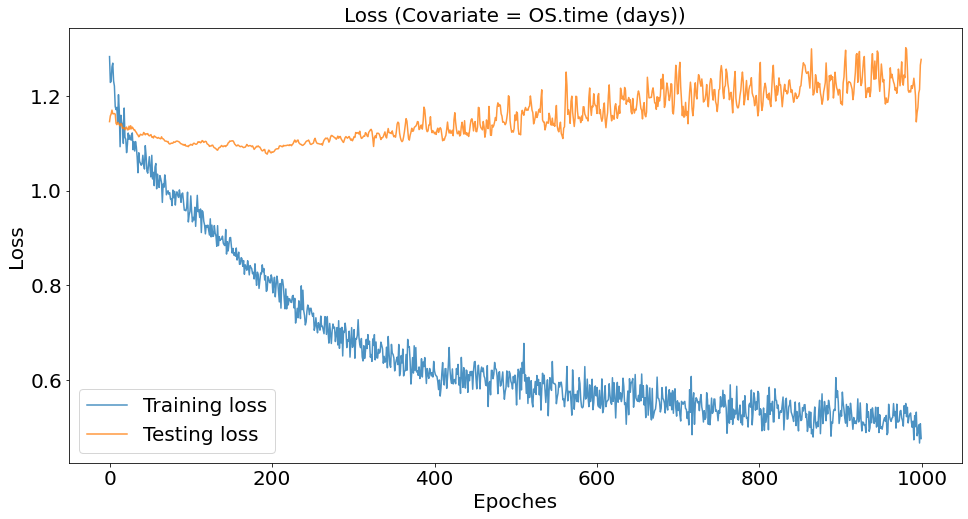

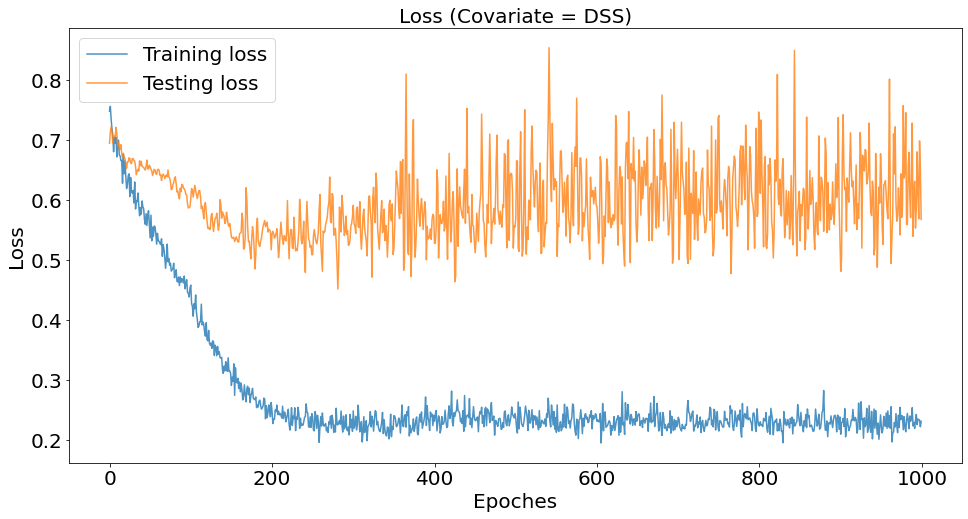

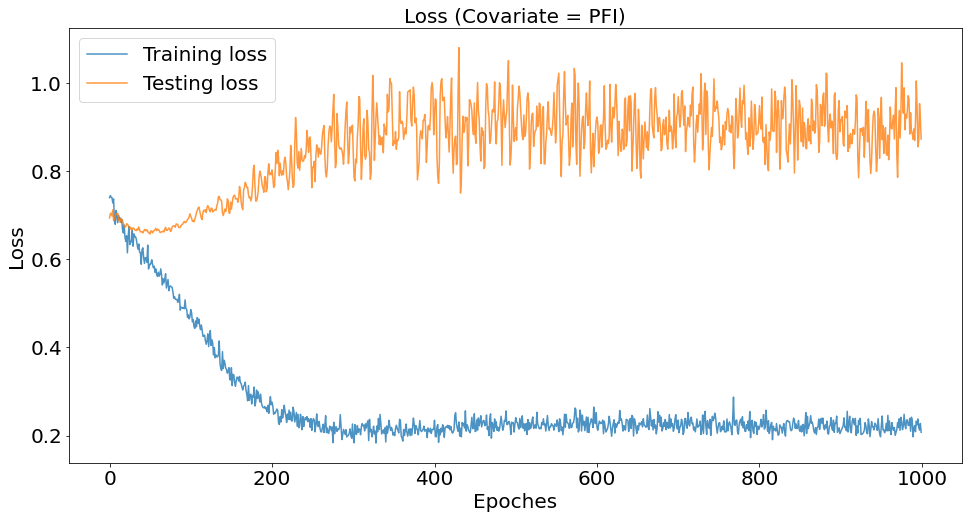

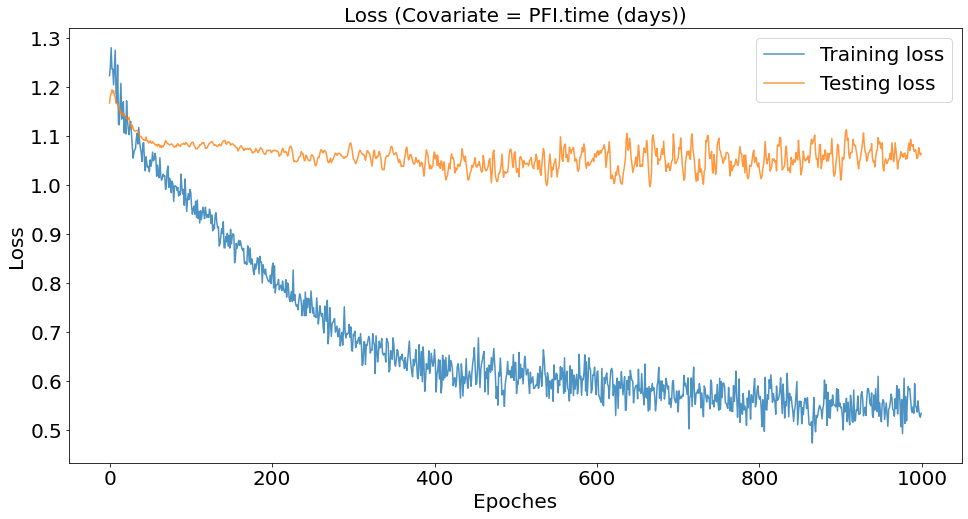

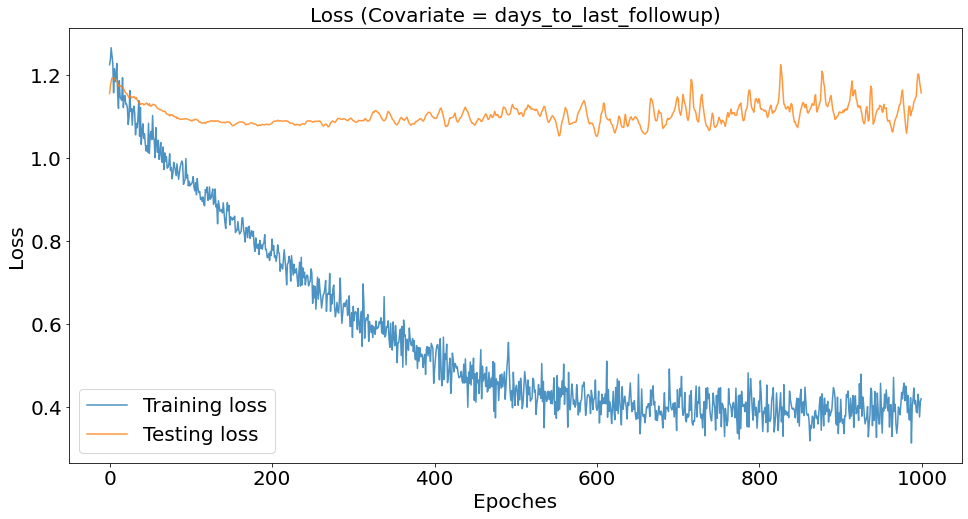

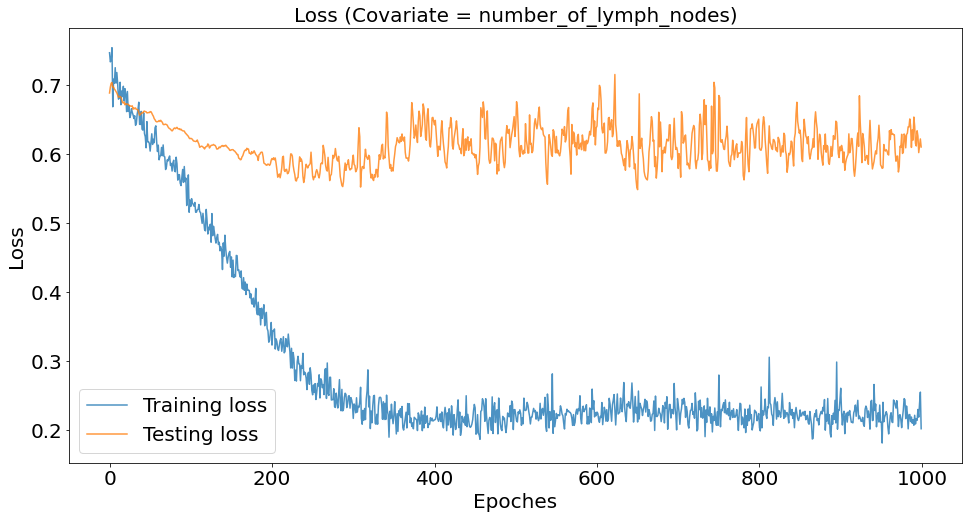

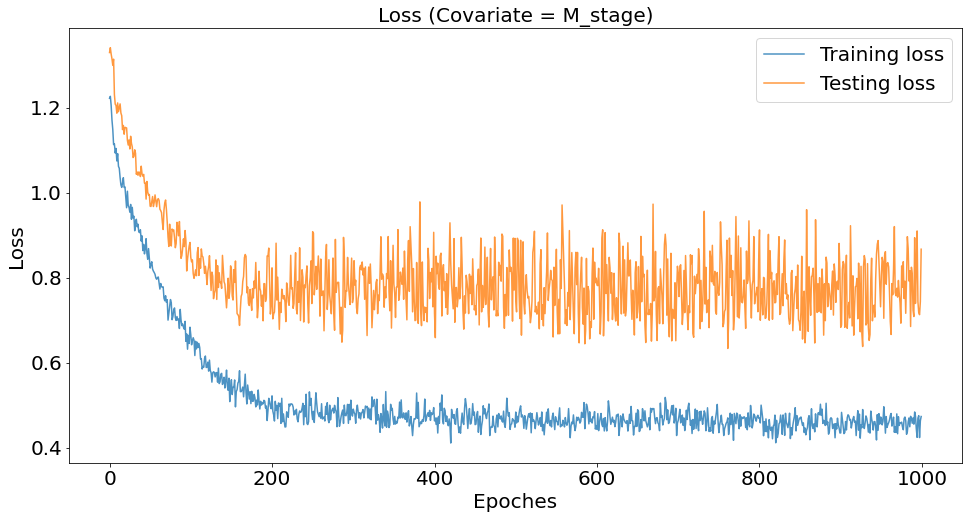

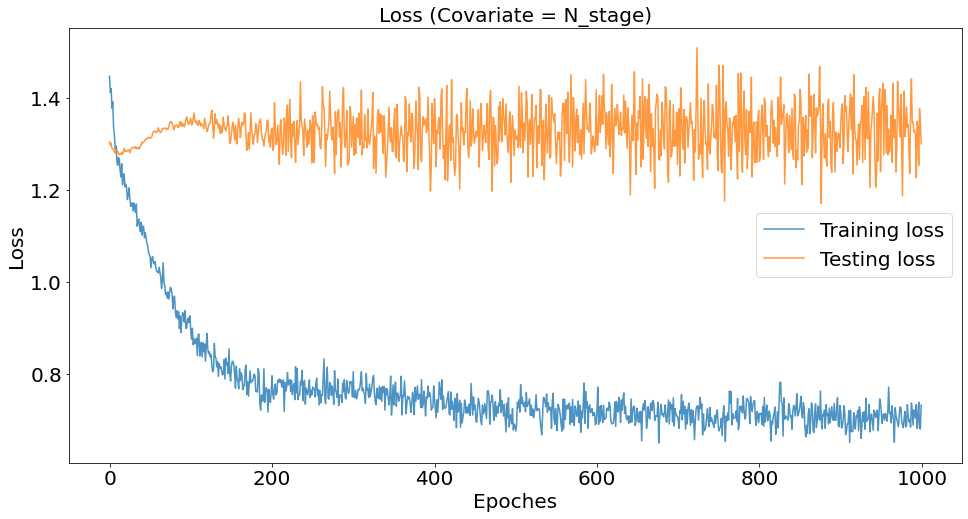

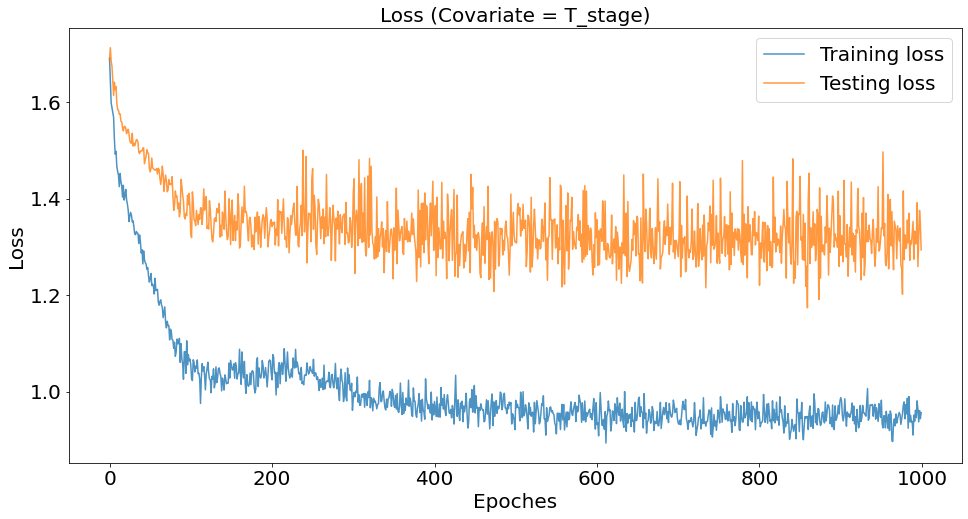

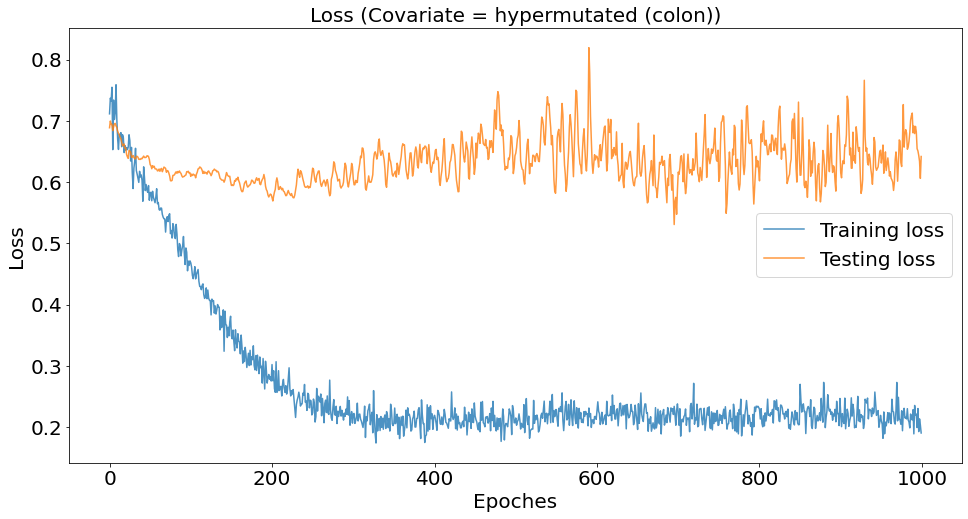

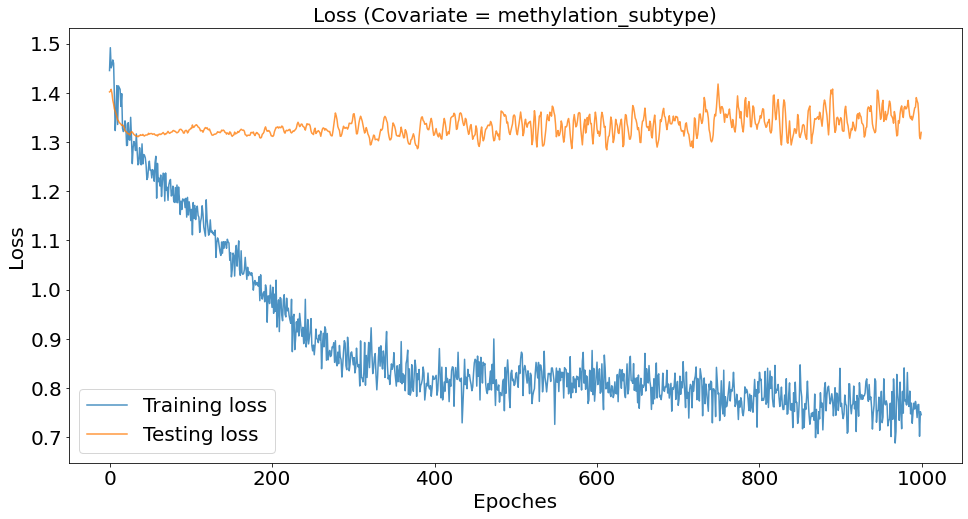

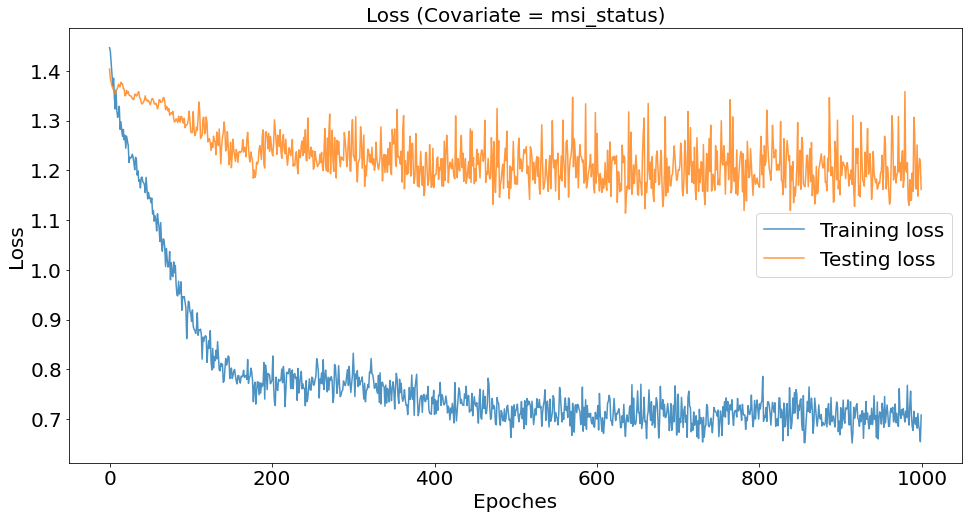

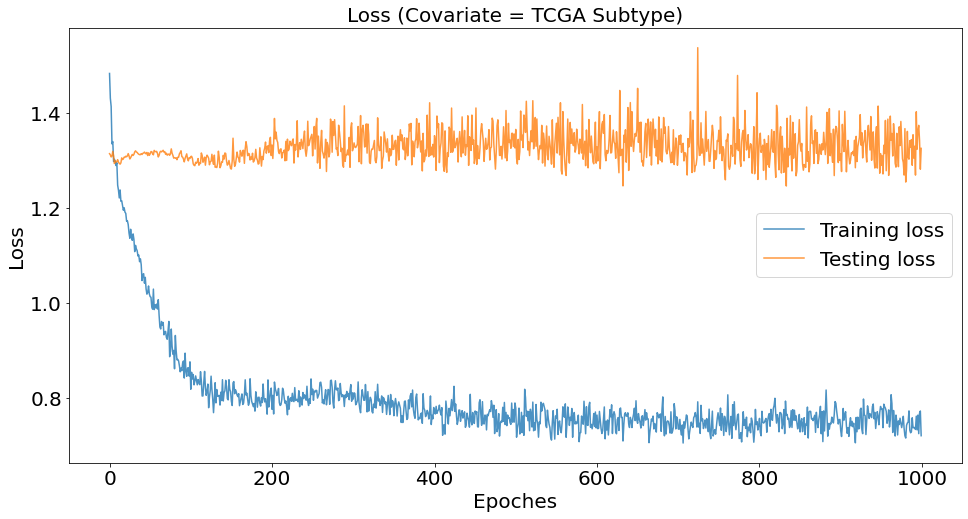

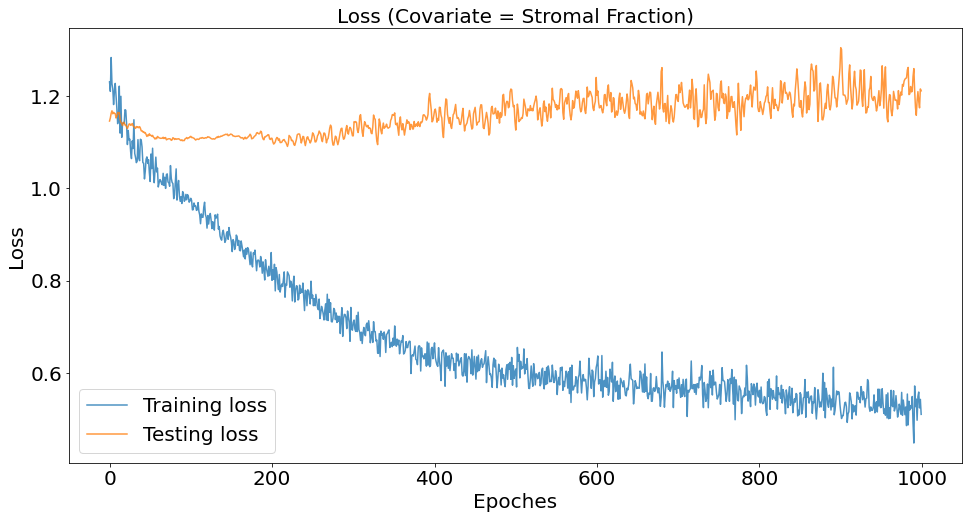

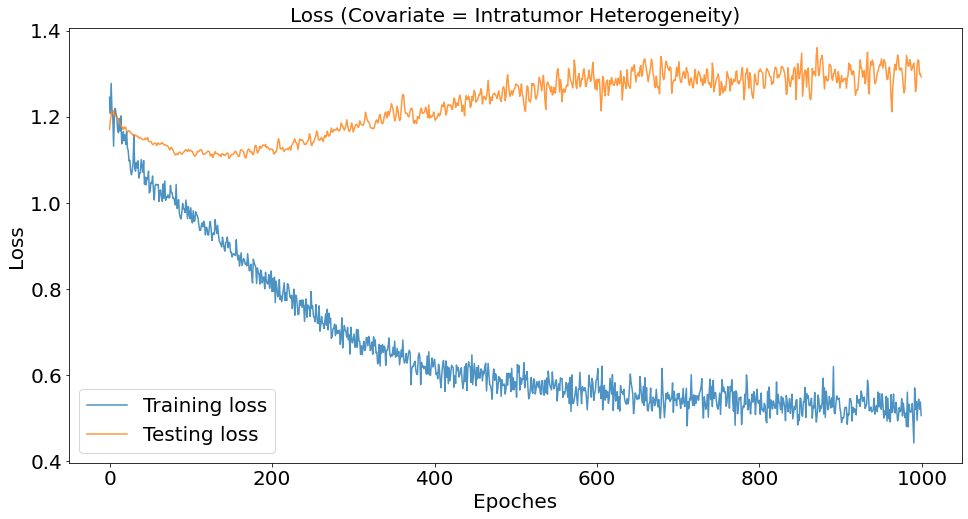

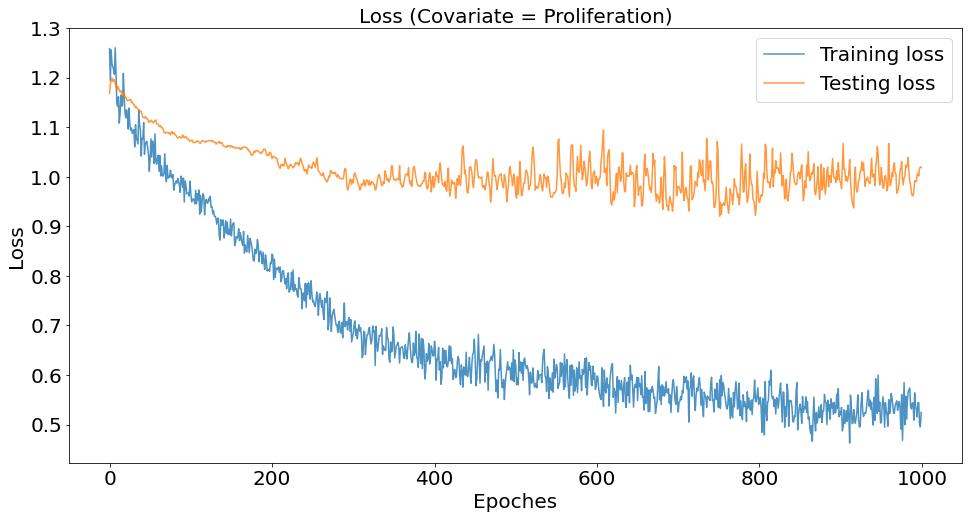

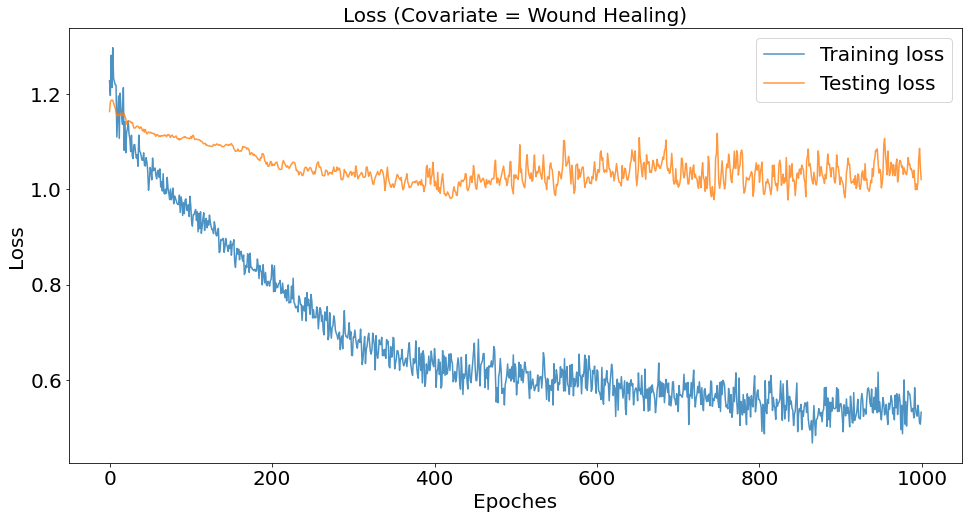

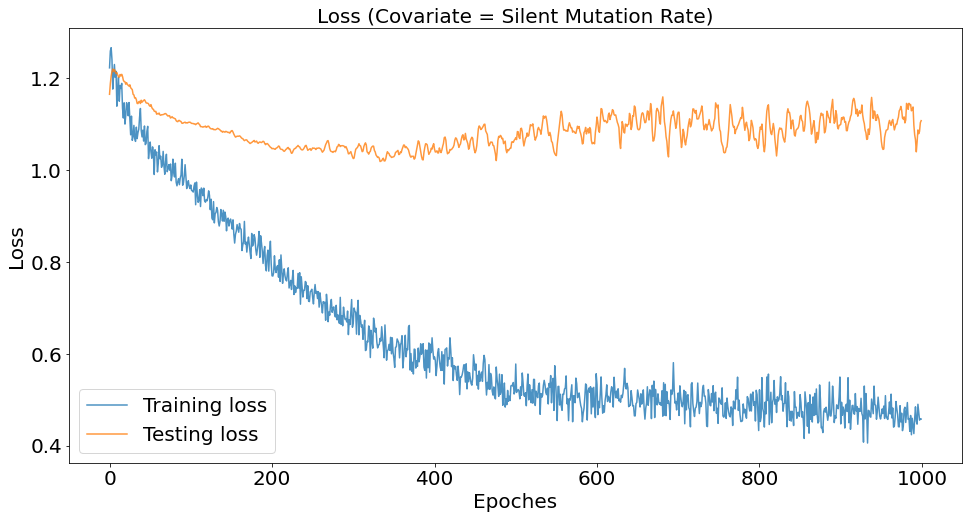

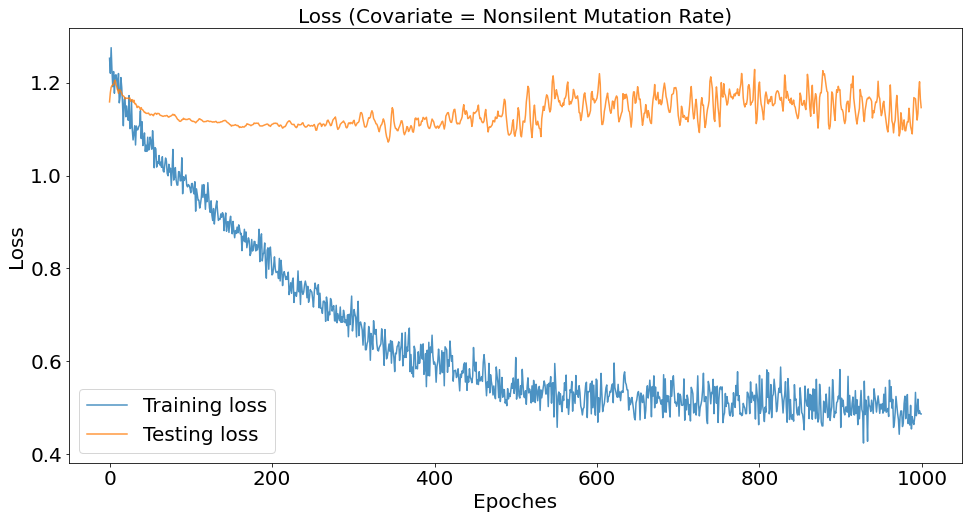

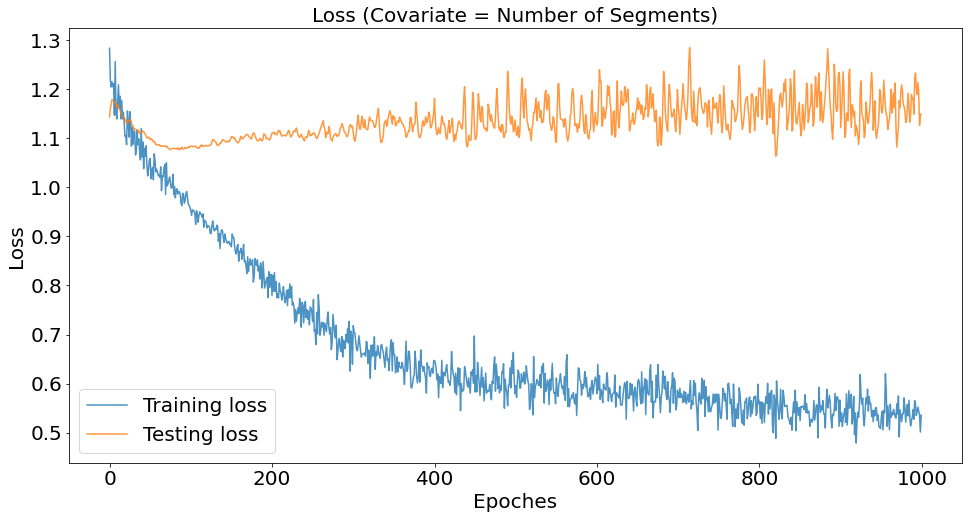

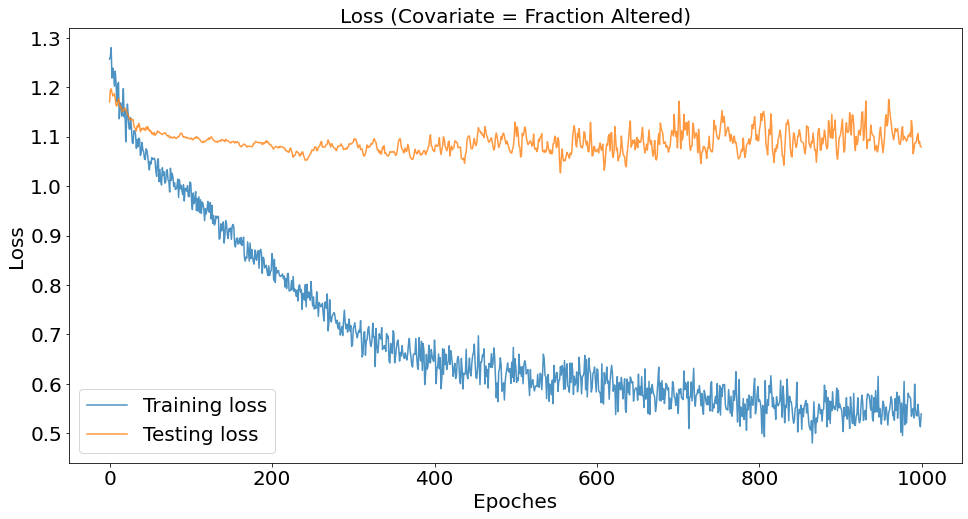

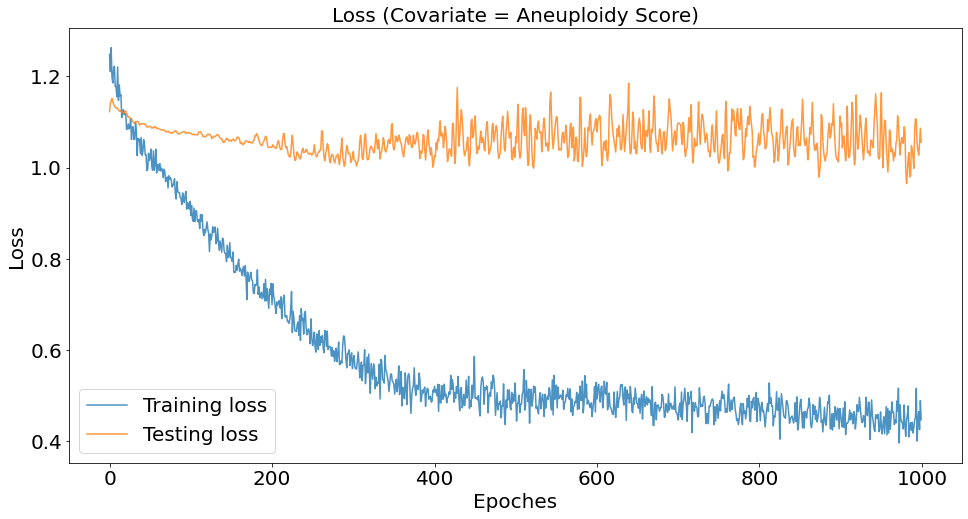

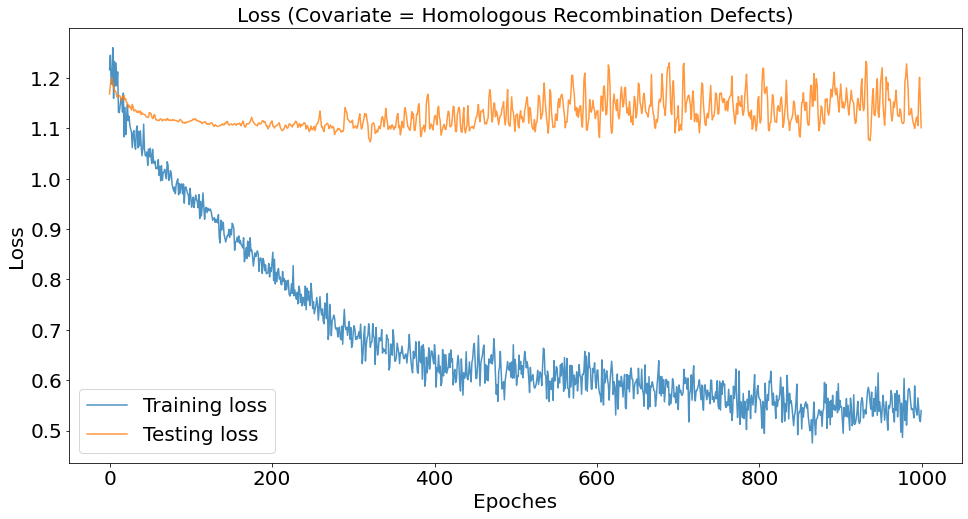

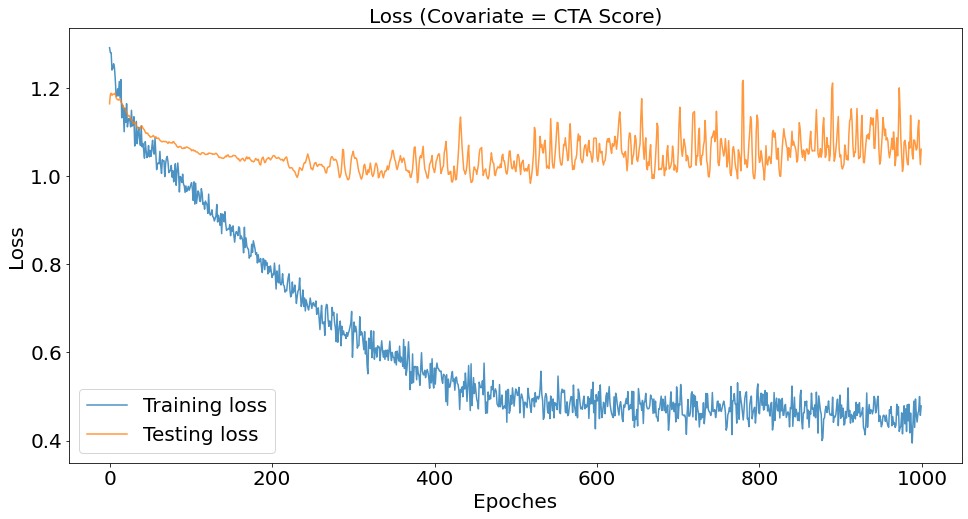

CPU times: user 20min 51s, sys: 42.3 s, total: 21min 33s
Wall time: 17min 23s


In [24]:
%%time
COAD_prediction_result_dict = train_mlp_all_cols('COAD', device=device)

In [25]:
COAD_prediction_result_dict['auc']

{'age_at_initial_pathologic_diagnosis': (0.5697887970615243,
  0.5633608815426997),
 'gender': (0.43526170798898073, 0.44117647058823534),
 'race': (0.8049886621315192, 0.5588235294117647),
 'ajcc_pathologic_tumor_stage': (0.5997658688865765, 0.5432051511366692),
 'Merged_stage (pathologic priority, clinical as backup)': (0.5654266389177939,
  0.5346875077566184),
 'histological_type': (0.8806244260789715, 0.5948275862068966),
 'initial_pathologic_dx_year': (0.6340679522497705, 0.5948051948051948),
 'birth_days_to': (0.4931129476584022, 0.5261707988980717),
 'vital_status': (0.5298438934802571, 0.3956521739130435),
 'tumor_status': (0.6576482830385016, 0.6842105263157895),
 'last_contact_days_to': (0.5136, 0.5316176470588235),
 'OS (dead=1)': (0.5298438934802571, 0.3956521739130435),
 'OS.time (days)': (0.4421487603305785, 0.4512830165004078),
 'DSS': (0.809573361082206, 0.5533333333333332),
 'PFI': (0.5307621671258035, 0.44907407407407407),
 'PFI.time (days)': (0.6225895316804407, 0.6

In [32]:
len(list(COAD_prediction_result_dict['auc'].keys()))

36

In [26]:
np.sort([x[0] for x in COAD_prediction_result_dict['auc'].values()])[::-1]

array([0.88062443, 0.81103516, 0.80957336, 0.80498866, 0.80440771,
       0.78459938, 0.77430556, 0.77376302, 0.68977865, 0.66942149,
       0.66942149, 0.66758494, 0.65764828, 0.65702479, 0.65350474,
       0.64967048, 0.63406795, 0.62258953, 0.60284665, 0.59976587,
       0.58722222, 0.57529844, 0.5697888 , 0.56542664, 0.55555556,
       0.555     , 0.53076217, 0.53076217, 0.52984389, 0.52984389,
       0.5136    , 0.49311295, 0.47704316, 0.44214876, 0.43526171,
       0.39348026])

In [27]:
np.sort([x[1] for x in COAD_prediction_result_dict['auc'].values()])[::-1]

array([0.76495726, 0.73109244, 0.69972452, 0.68595041, 0.68421053,
       0.67906336, 0.65732323, 0.65035647, 0.64592934, 0.63498623,
       0.6322314 , 0.61464748, 0.59917355, 0.59795508, 0.595     ,
       0.59482759, 0.59480519, 0.56336088, 0.55882353, 0.5546875 ,
       0.55333333, 0.54681548, 0.54320515, 0.53468751, 0.53298941,
       0.53166667, 0.53161765, 0.5261708 , 0.51599801, 0.46291258,
       0.45128302, 0.44907407, 0.44117647, 0.39565217, 0.39565217,
       0.37603306])

### STAD

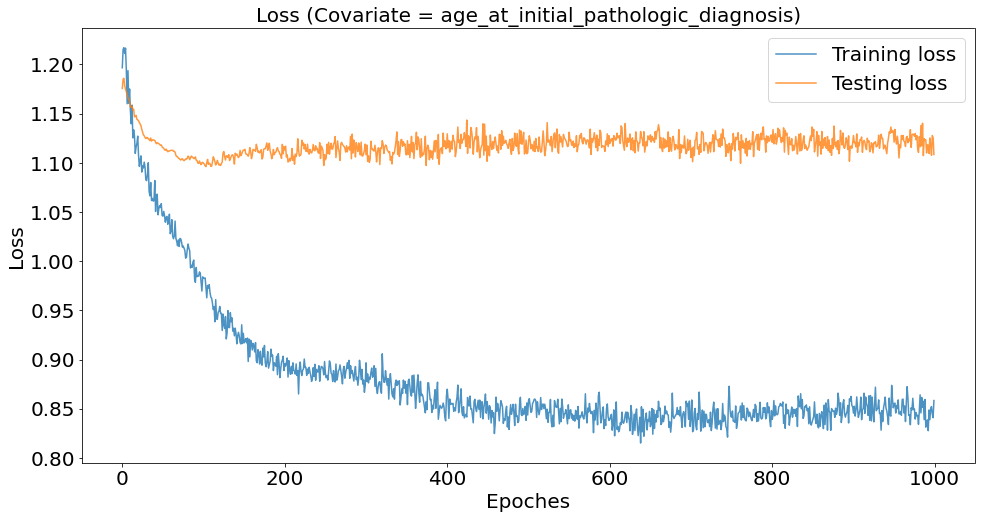

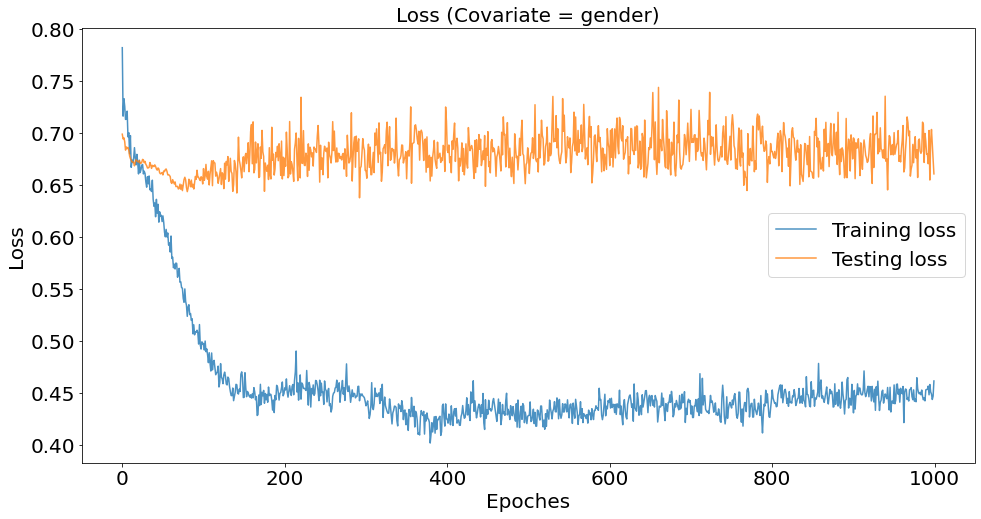

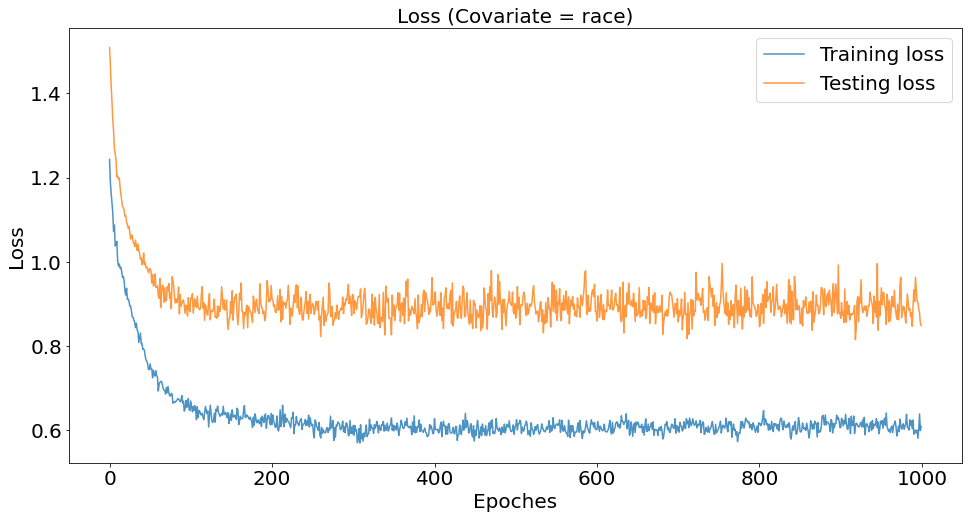

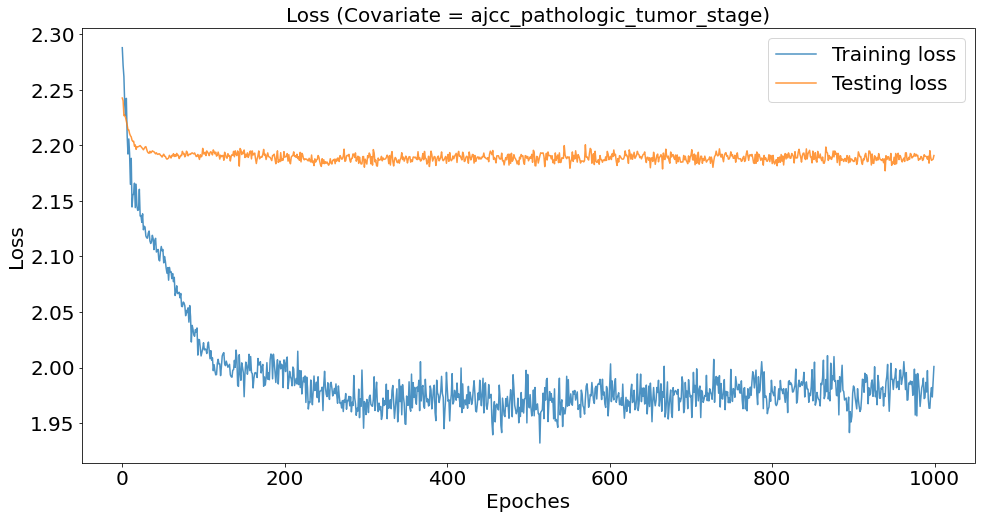

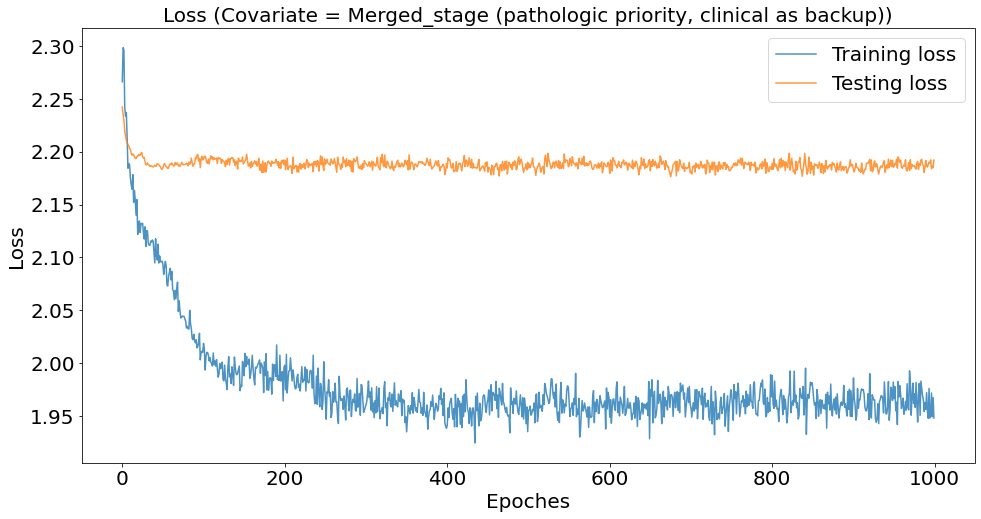

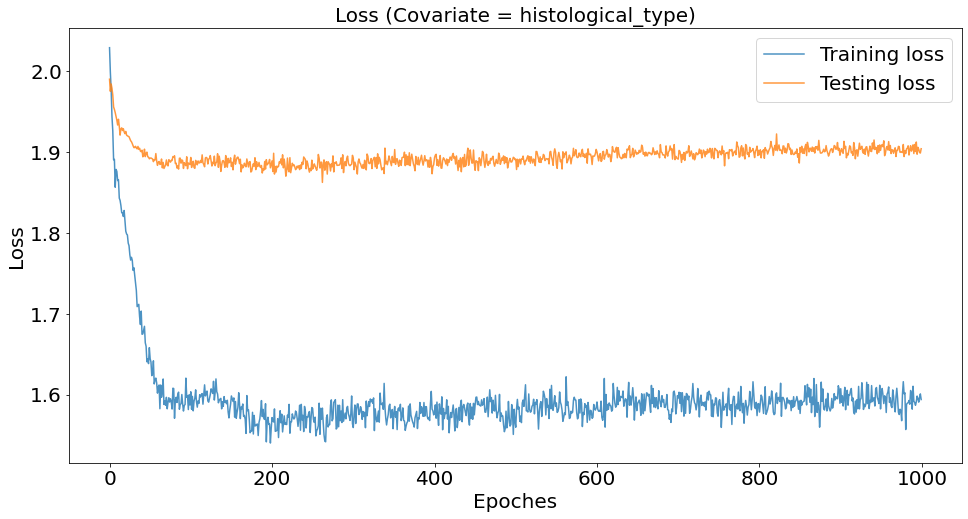

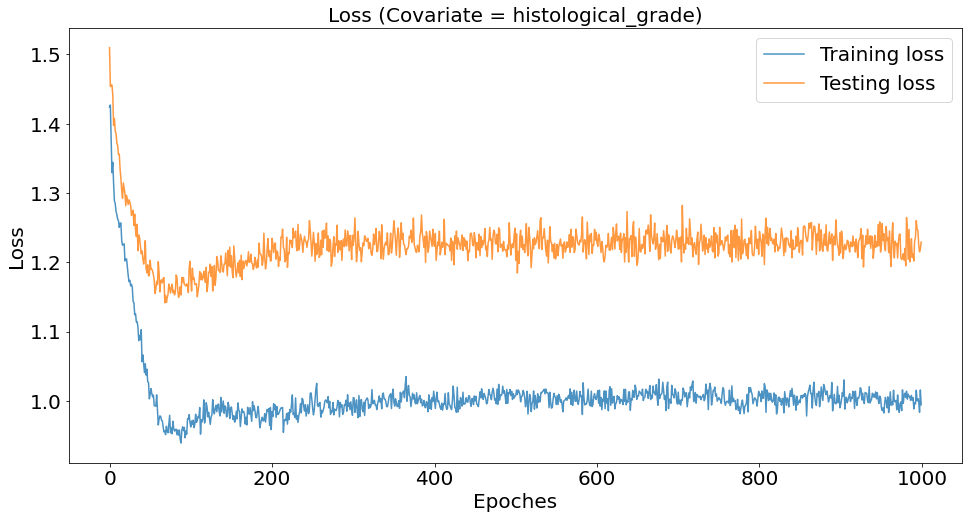

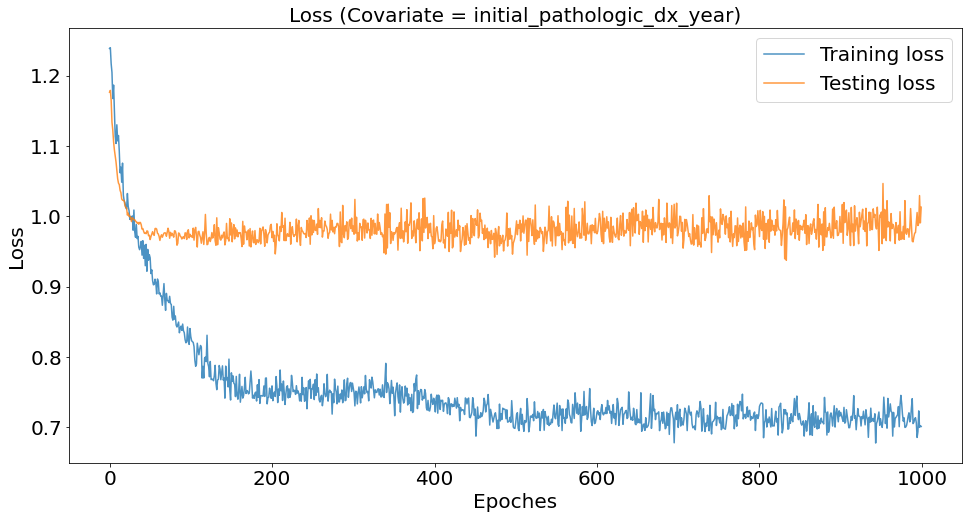

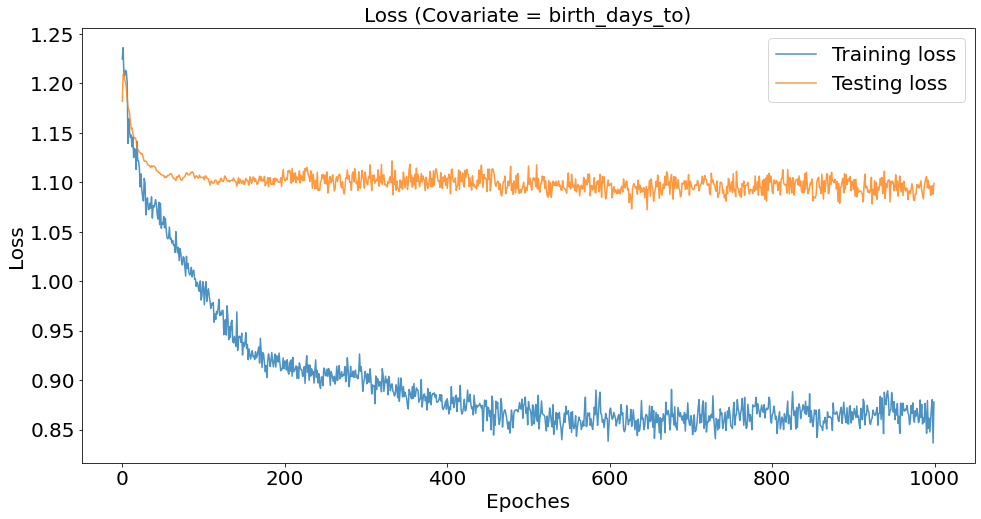

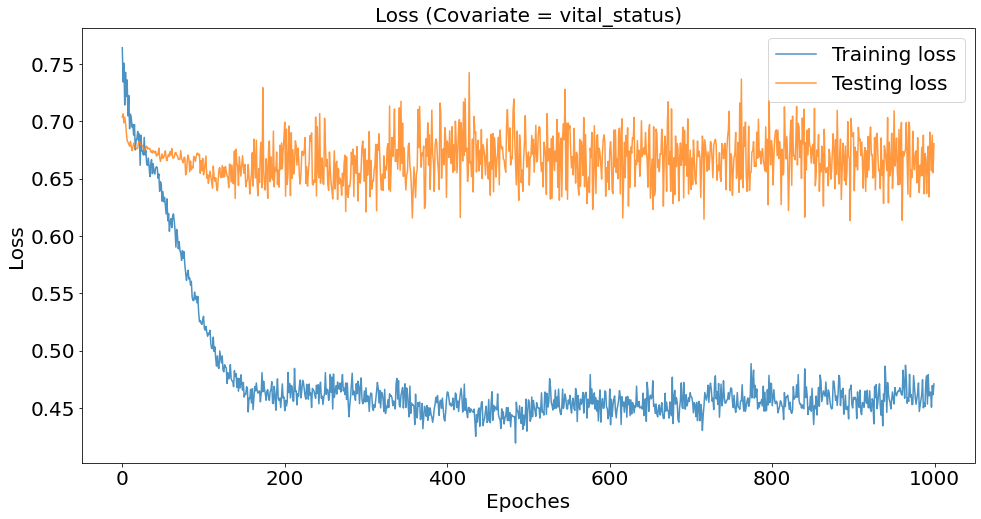

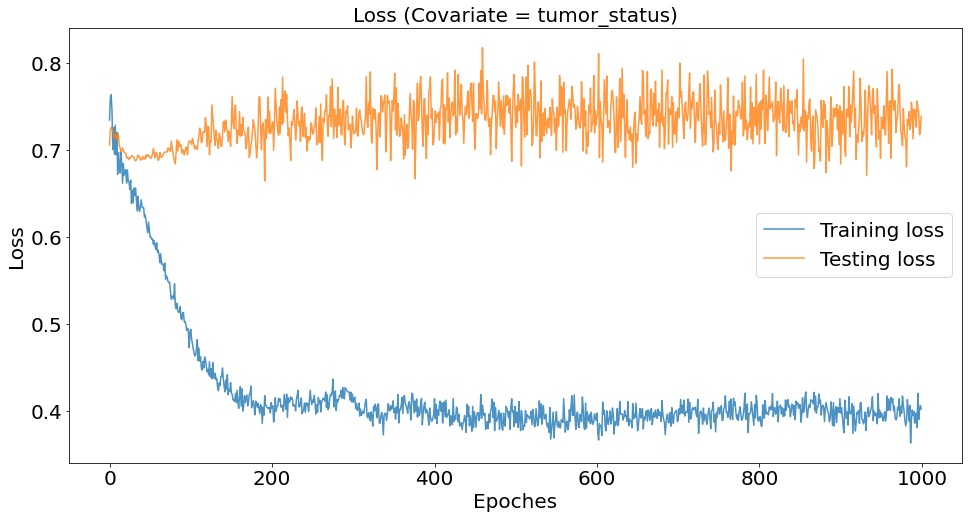

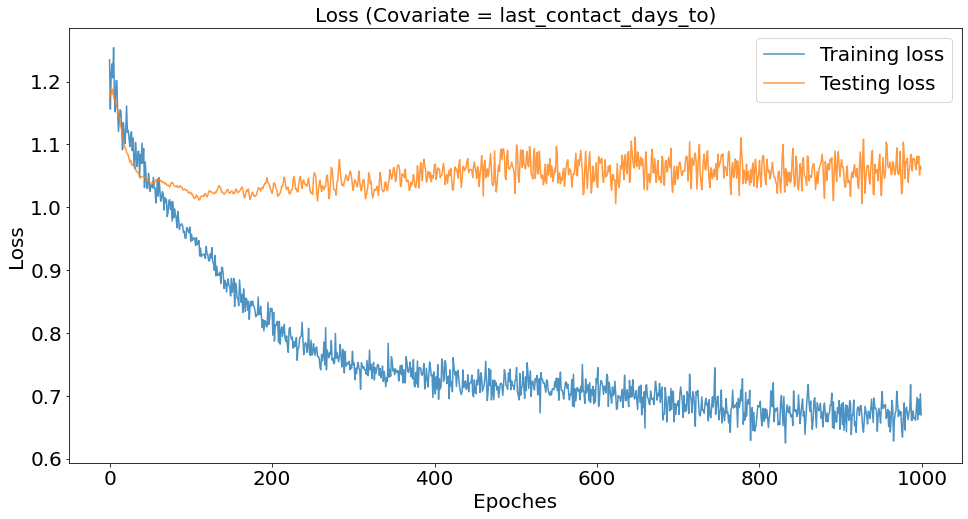

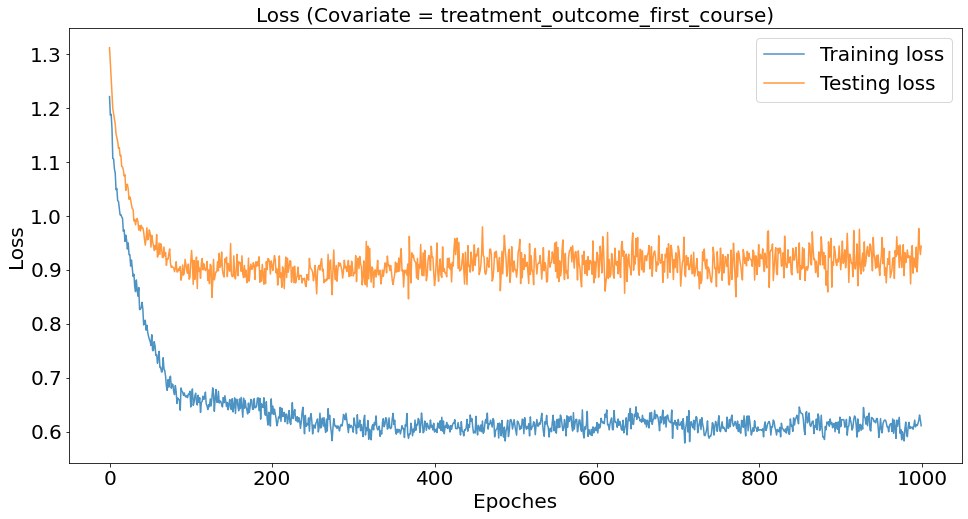

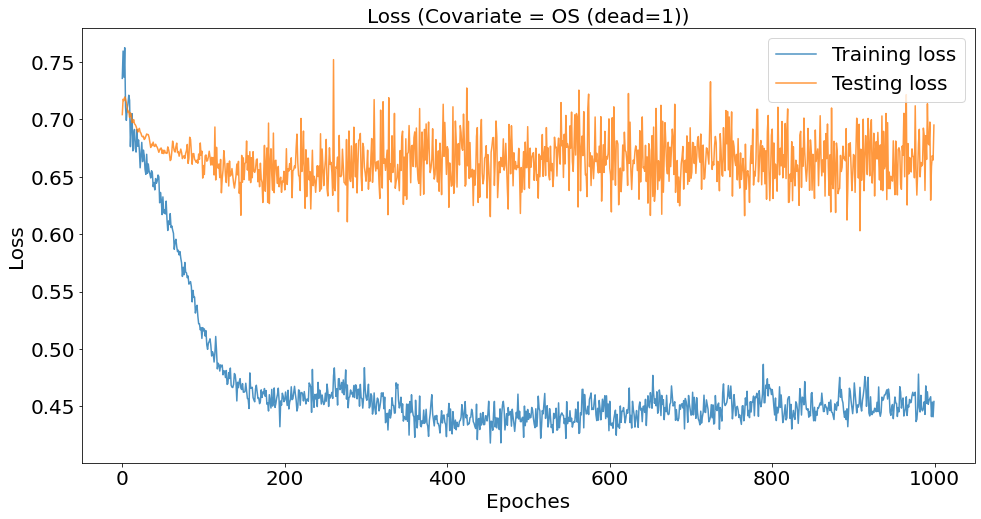

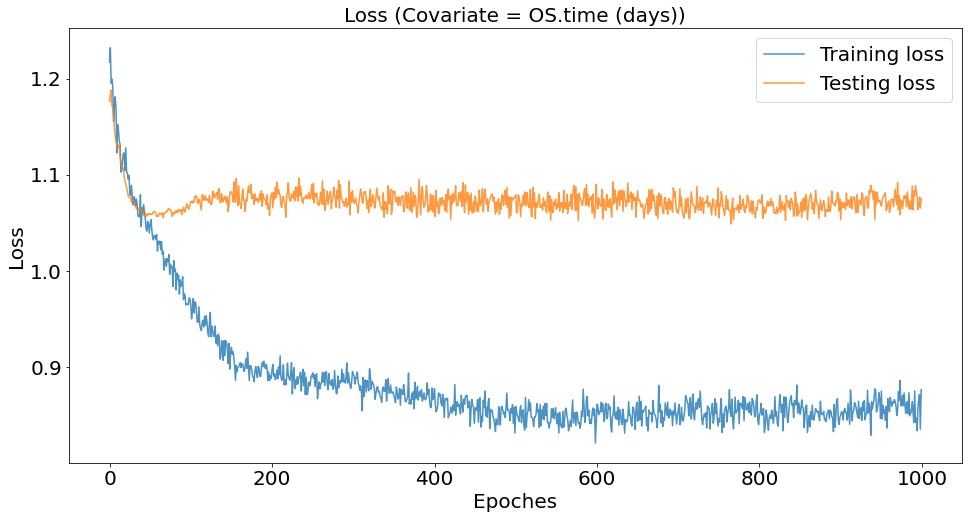

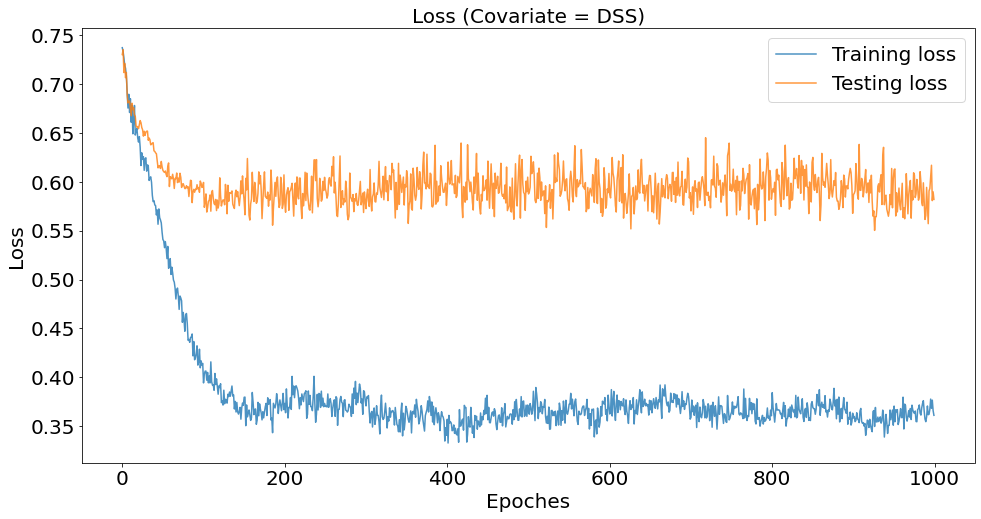

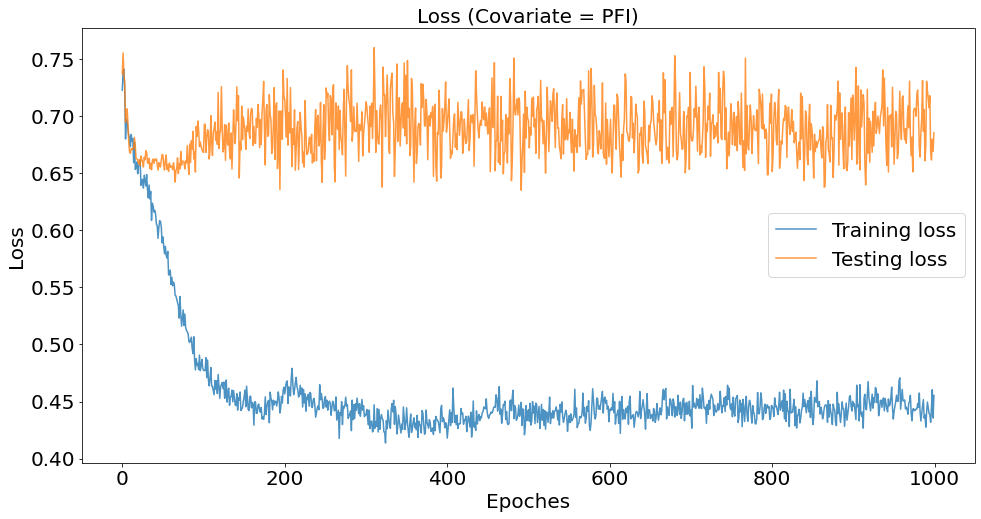

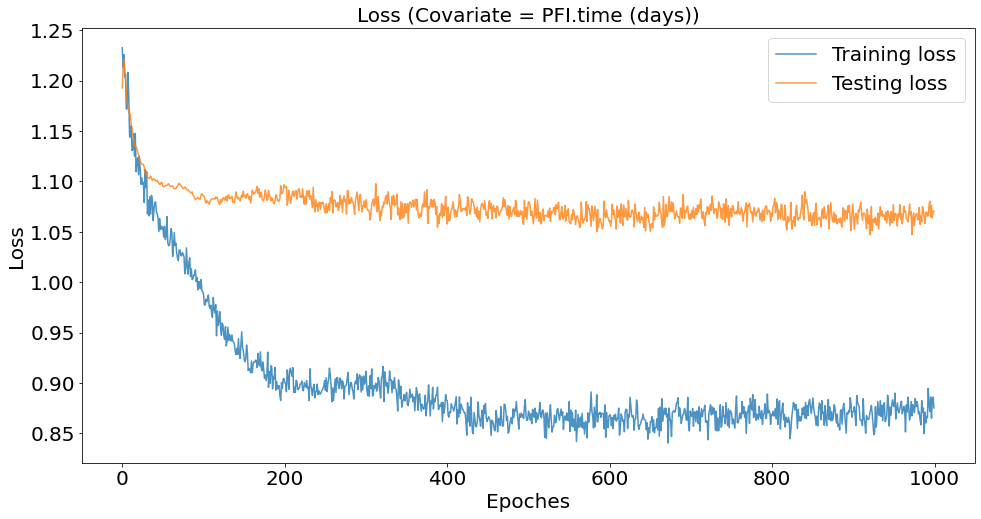

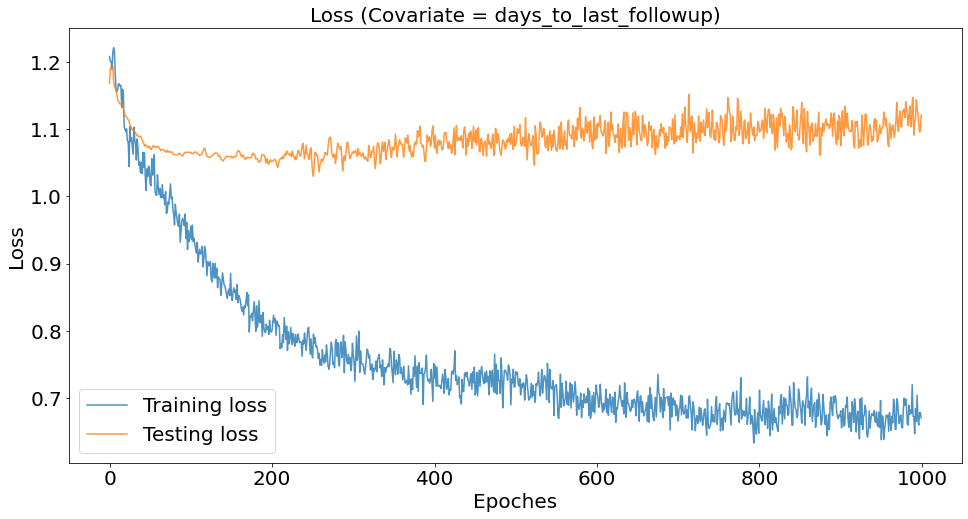

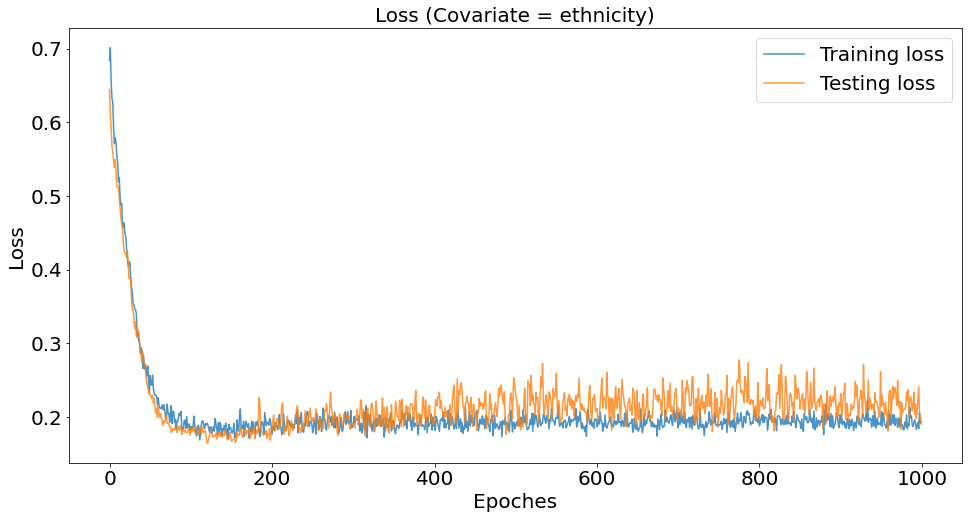

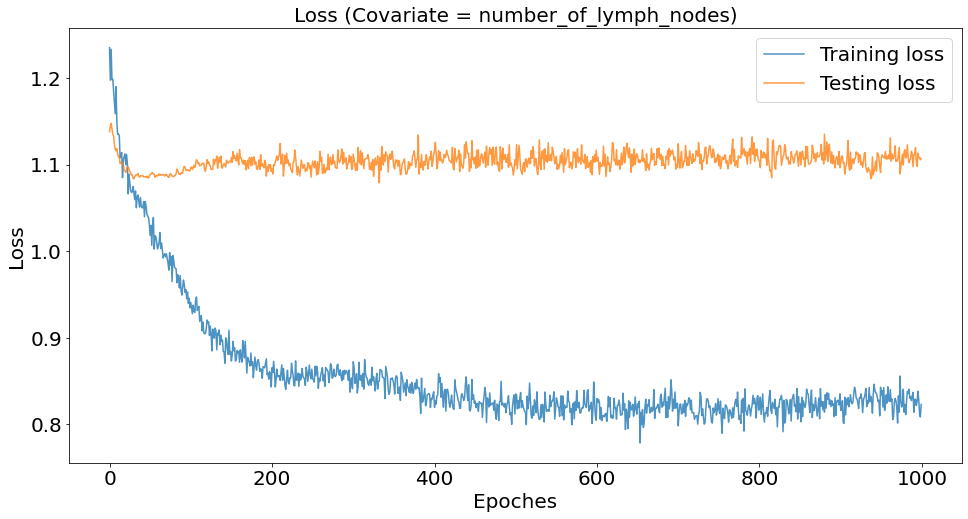

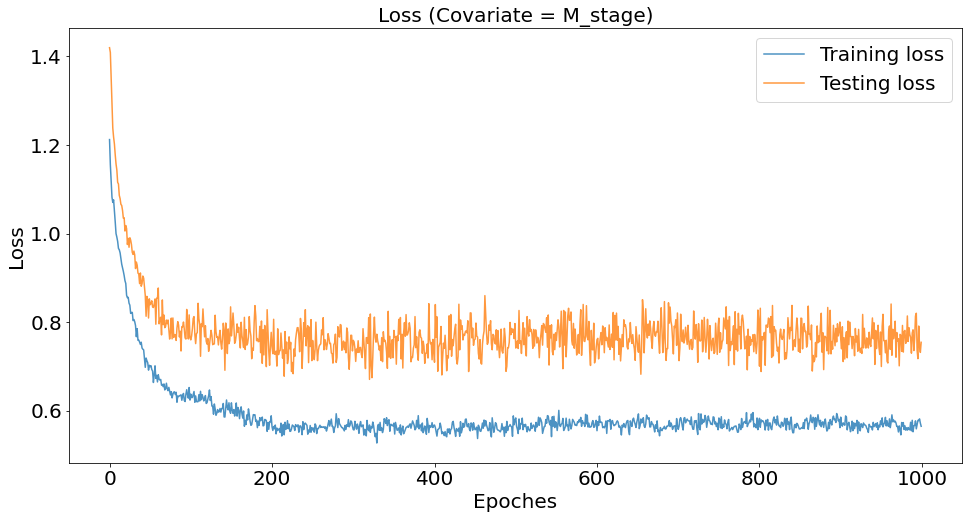

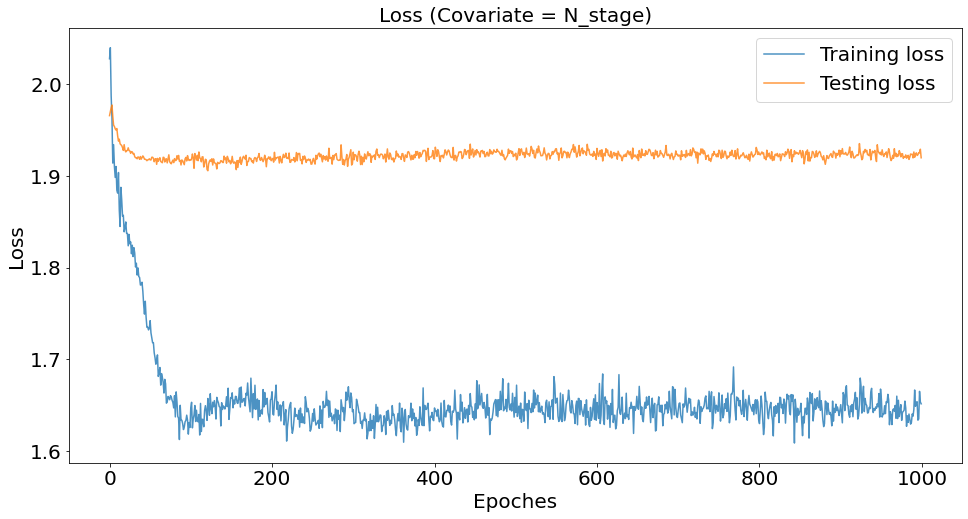

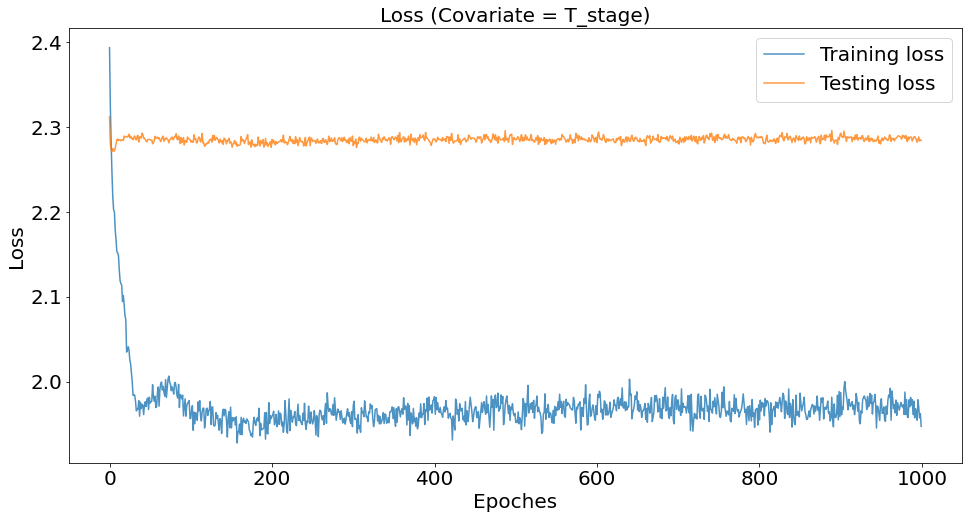

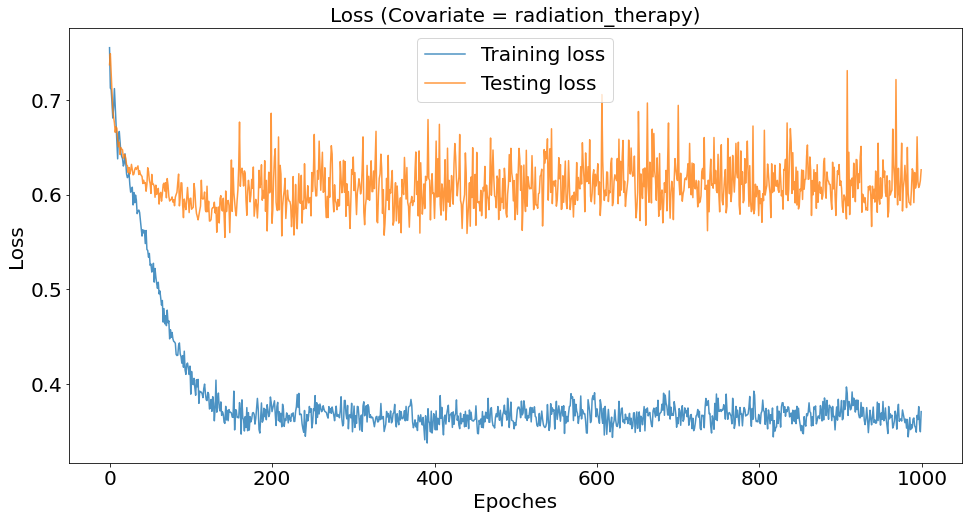

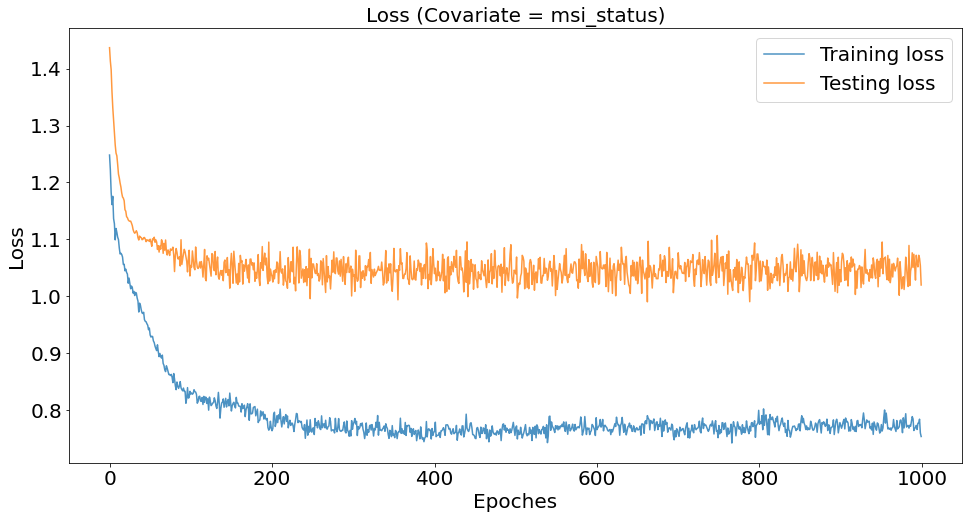

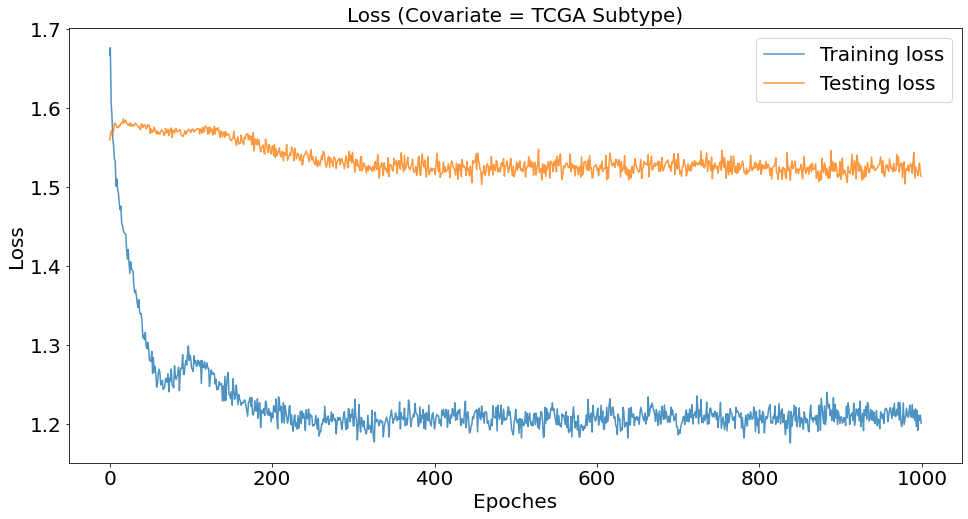

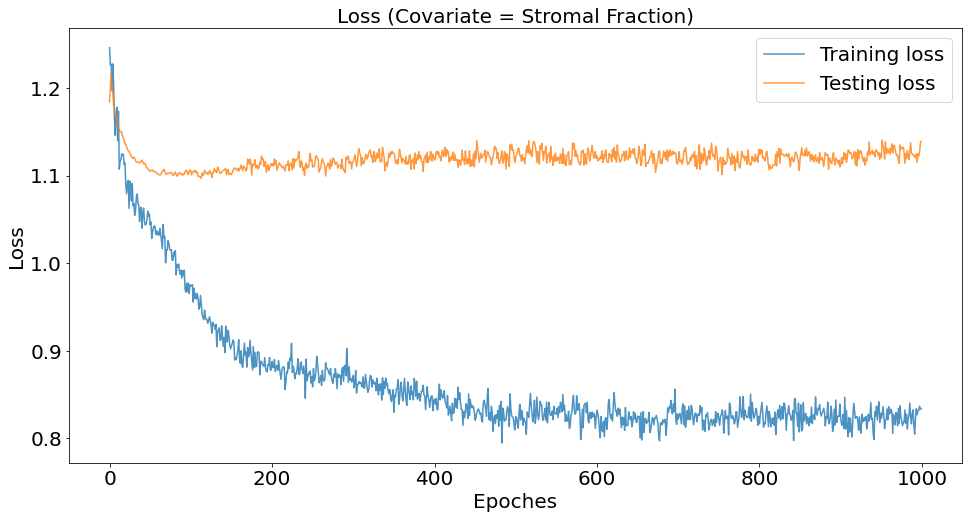

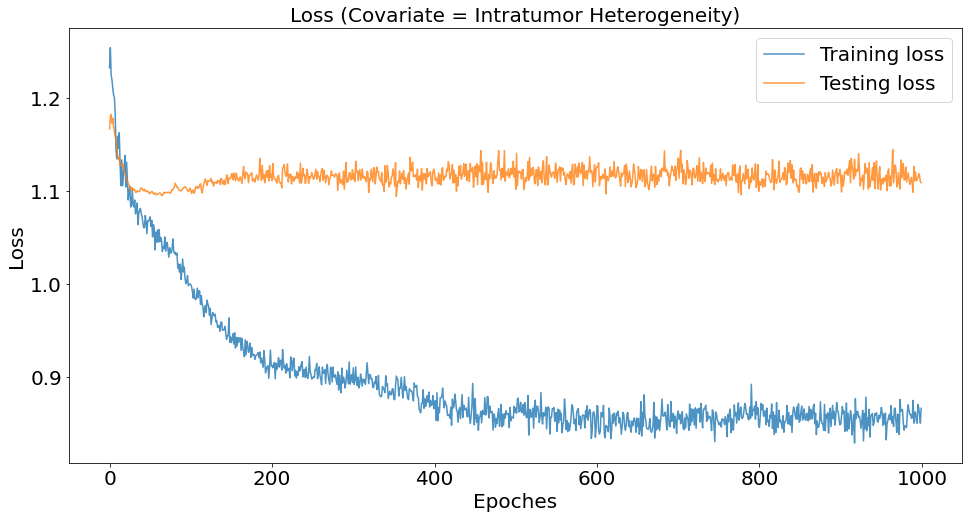

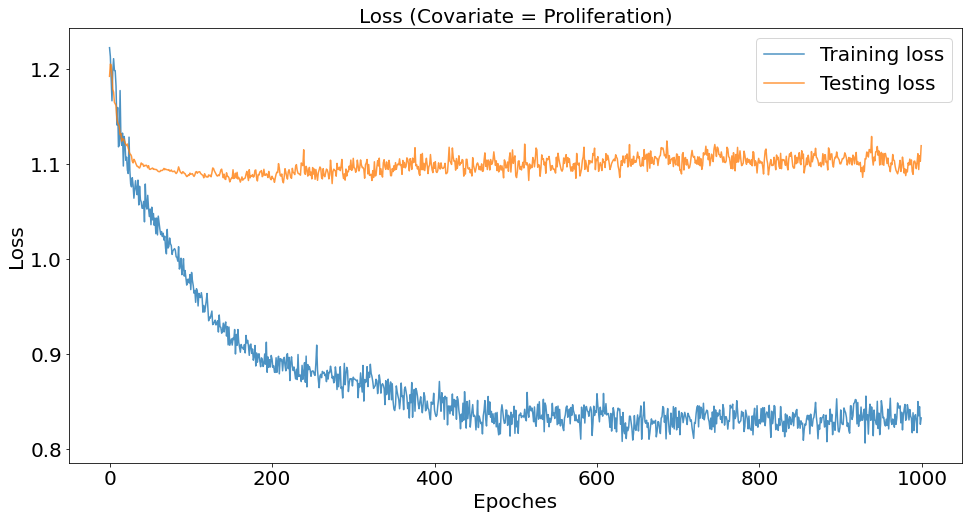

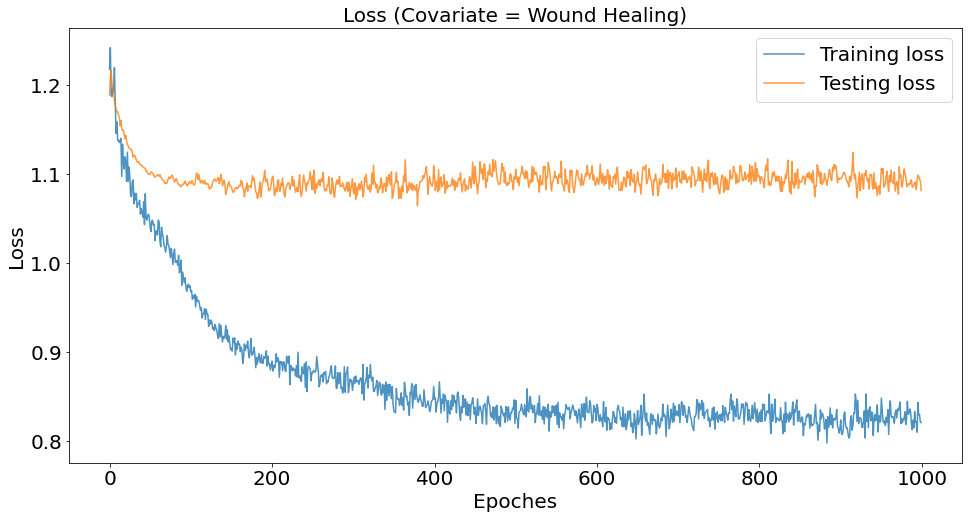

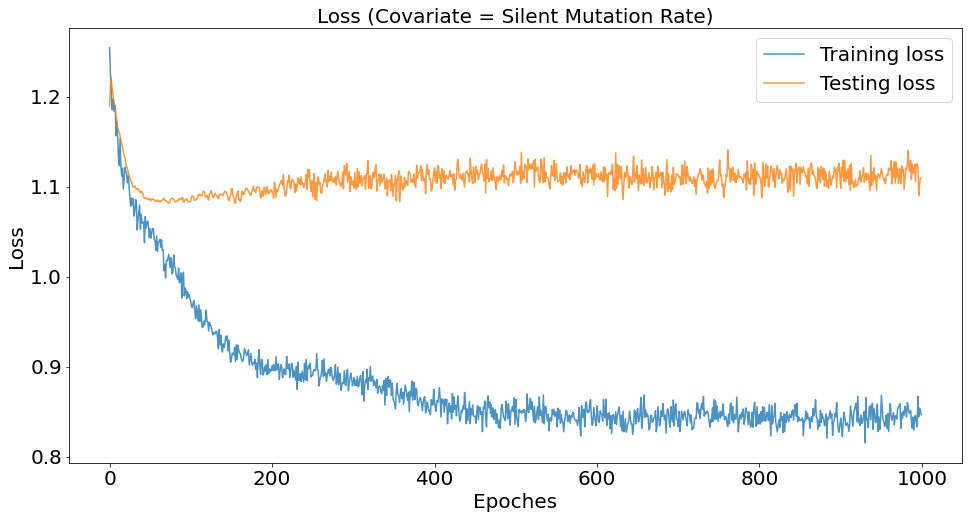

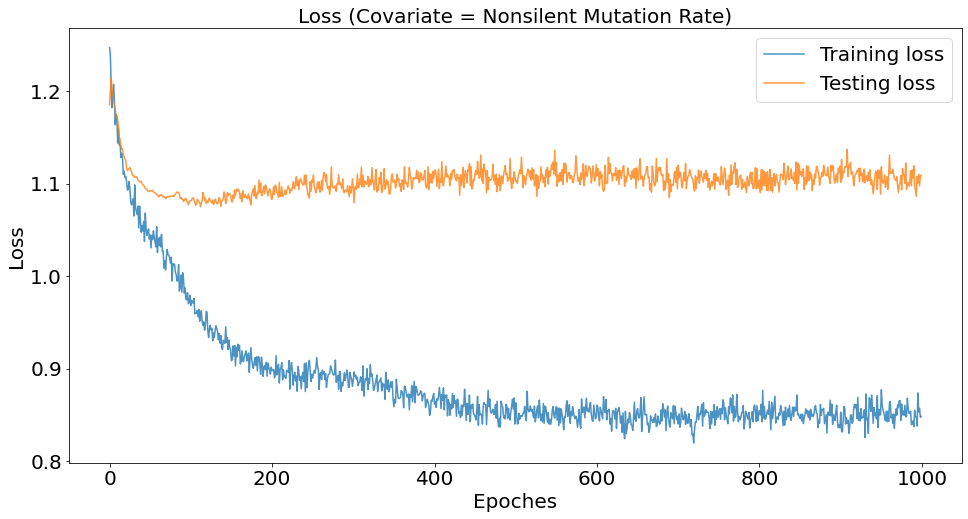

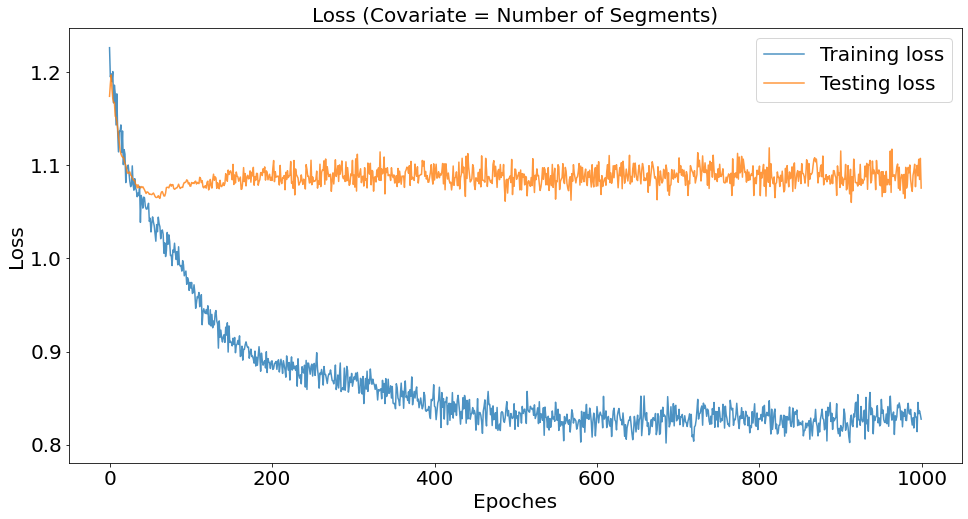

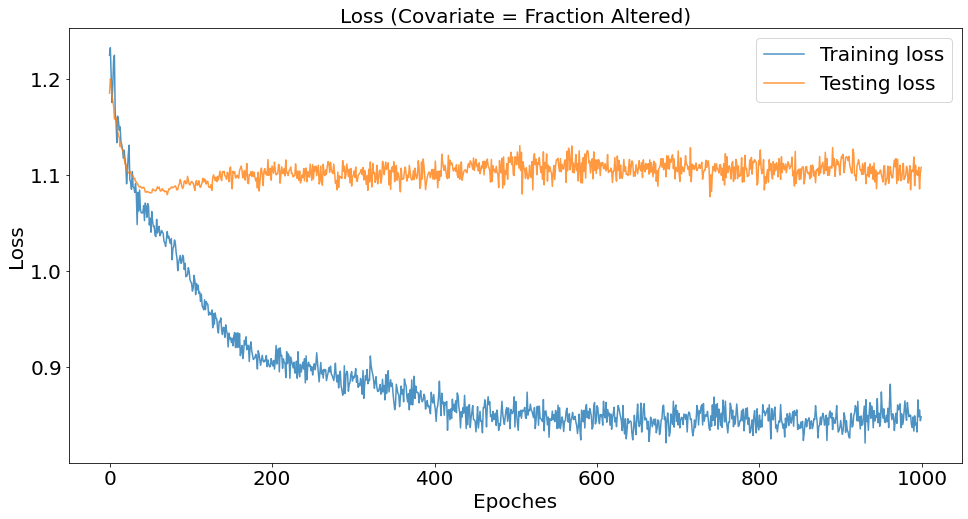

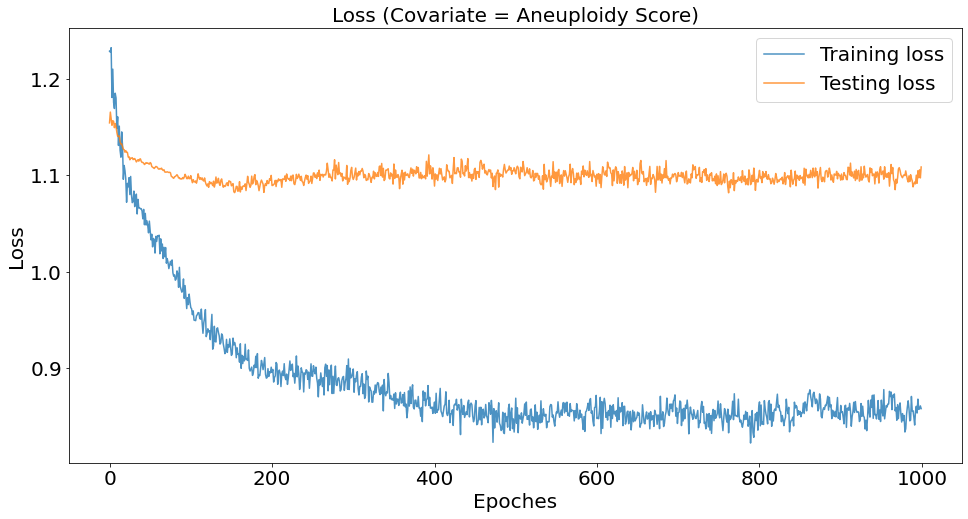

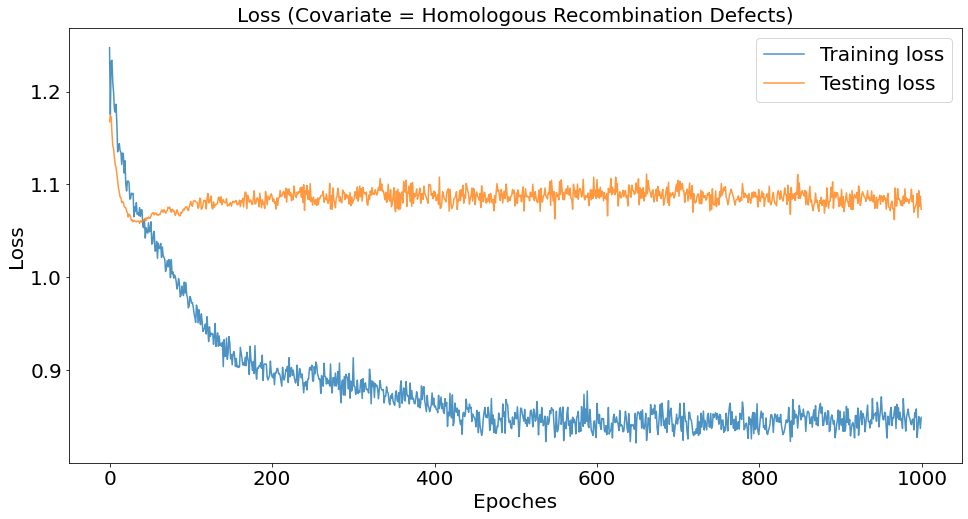

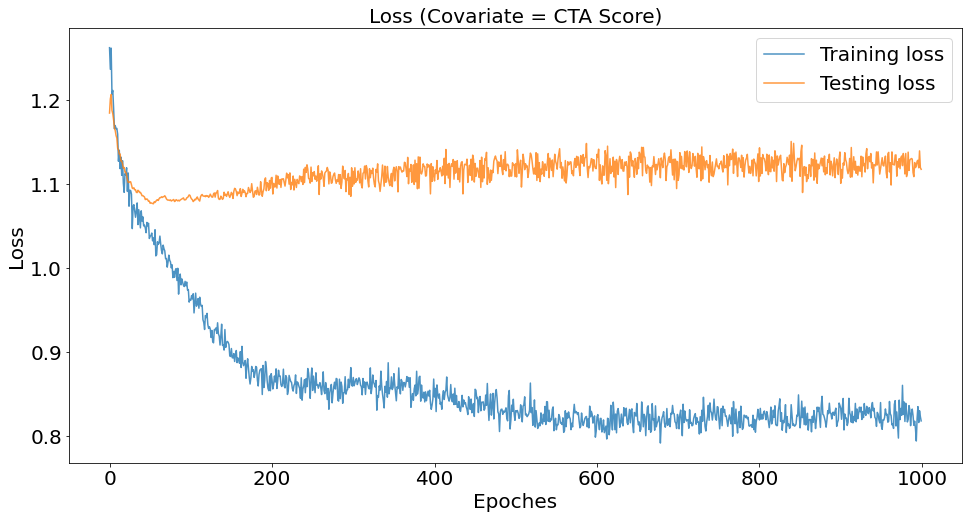

CPU times: user 44min 37s, sys: 1min 29s, total: 46min 7s
Wall time: 41min 25s


In [28]:
%%time
STAD_prediction_result_dict = train_mlp_all_cols('STAD', device=device)

In [29]:
STAD_prediction_result_dict['auc']

{'age_at_initial_pathologic_diagnosis': (0.515062326869806,
  0.5110020242914979),
 'gender': (0.6405817174515236, 0.5192307692307692),
 'race': (0.8345956783247939, 0.6074169124213021),
 'ajcc_pathologic_tumor_stage': (0.5722326919262051, 0.5144229221580786),
 'Merged_stage (pathologic priority, clinical as backup)': (0.5658847450902598,
  0.5107536616119194),
 'histological_type': (0.696300784856879, 0.5624481620012559),
 'histological_grade': (0.8041897506925207, 0.6323353688742969),
 'initial_pathologic_dx_year': (0.6820463988919667, 0.6819331983805669),
 'birth_days_to': (0.519736842105263, 0.5235036119711043),
 'vital_status': (0.5950484764542936, 0.6089508437270726),
 'tumor_status': (0.49859429065743943, 0.4782196969696969),
 'last_contact_days_to': (0.619357638888889, 0.6197916666666666),
 'treatment_outcome_first_course': (0.7624086671705719, 0.5898544973544974),
 'OS (dead=1)': (0.590027700831025, 0.5685986793837124),
 'OS.time (days)': (0.6055228531855955, 0.609453044375645

In [33]:
len(list(STAD_prediction_result_dict['auc'].keys()))

38

In [30]:
np.sort([x[0] for x in STAD_prediction_result_dict['auc'].values()])[::-1]

array([0.97476147, 0.88322368, 0.83459568, 0.80418975, 0.78819444,
       0.76240867, 0.73086911, 0.71224533, 0.69630078, 0.6820464 ,
       0.68124808, 0.67679478, 0.67494806, 0.64058172, 0.61935764,
       0.61824792, 0.60742729, 0.60552285, 0.59911704, 0.59504848,
       0.59324444, 0.5900277 , 0.57929363, 0.57223269, 0.56588475,
       0.54119511, 0.53220222, 0.53047091, 0.52605969, 0.51973684,
       0.51964444, 0.51506233, 0.50551111, 0.49859429, 0.49671053,
       0.49220914, 0.48900463, 0.45697778])

In [31]:
np.sort([x[1] for x in STAD_prediction_result_dict['auc'].values()])[::-1]

array([0.6819332 , 0.63233537, 0.62139037, 0.61979167, 0.60945304,
       0.60895084, 0.60741691, 0.60714286, 0.6052838 , 0.60148553,
       0.59596491, 0.59579725, 0.5898545 , 0.57772436, 0.57770382,
       0.56859868, 0.56244816, 0.55743709, 0.54620736, 0.53967914,
       0.53837241, 0.53397045, 0.52705366, 0.52524768, 0.52468639,
       0.52350361, 0.51923077, 0.51442292, 0.51100202, 0.51075366,
       0.5072641 , 0.5006662 , 0.49716718, 0.49443756, 0.48726852,
       0.4782197 , 0.44875646, 0.28571429])